In [1]:
# =============================================================================
# NOTEBOOK SETUP - Two Population Delay Sweep Execution
# =============================================================================
import os
import sys
from pathlib import Path

# Robust directory setup
if Path.cwd().name == 'two_populations':
    os.chdir("../../")
    
from src.two_populations.helpers.logger import setup_logger

logger = setup_logger(
    experiment_name="delay_sweep_gaussian",
    console_level="INFO",
    file_level="DEBUG",
    log_to_file=False
)

logger.info(f"Working directory: {Path.cwd()}")
logger.info(f"Python path: {sys.path[0]}")

INFO     | __main__:<module>:21 - Working directory: /home/ubuntu-deduce/Projects/izhikevich
INFO     | __main__:<module>:22 - Python path: /home/ubuntu-deduce/.asdf/installs/python/3.10.13/lib/python310.zip


In [2]:
# =============================================================================
# BRIAN2 SETUP
# =============================================================================
from brian2 import *

# Performance optimization for standalone compilation
os.environ['CXXFLAGS'] = '-fopenmp -O3'
os.environ['LDFLAGS'] = '-lgomp'

# Clean slate
restore_initial_state()

# =============================================================================
# DEVICE CONFIGURATION
# =============================================================================
# Options: 'runtime', 'cpp_standalone', 'cuda_standalone'
DEVICE_MODE = 'runtime'  # Change this for performance

# Hardware detection
import multiprocessing
N_CORES = multiprocessing.cpu_count()
logger.info(f"Available CPU cores: {N_CORES}")

if DEVICE_MODE == 'cpp_standalone':
    set_device('cpp_standalone', directory='brian2_output', build_on_run=True)
    prefs.devices.cpp_standalone.openmp_threads = min(N_CORES, 20)  # Adaptive
    logger.info(f"[DEVICE] cpp_standalone with {prefs.devices.cpp_standalone.openmp_threads} threads")

elif DEVICE_MODE == 'cuda_standalone':
    try:
        # from brian2cuda import *  # Uncomment if available
        set_device('cuda_standalone', directory='brian2_cuda_output', build_on_run=False)
        logger.info("[DEVICE] cuda_standalone enabled")
    except ImportError:
        logger.info("[WARNING] brian2cuda not available, falling back to cpp_standalone")
        set_device('cpp_standalone', directory='brian2_output', build_on_run=True)
        
else:  # runtime
    logger.info(f"[DEVICE] runtime mode (single-threaded)")

logger.info(f"Brian2 device: {get_device()}")
logger.info("=" * 60)

/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(
INFO       Available CPU cores: 12 [brian2]
INFO       [DEVICE] runtime mode (single-threaded) [brian2]
INFO       Brian2 device: <brian2.devices.device.RuntimeDevice object at 0x7ff22f5c2830> [brian2]
INFO       ============================================================ [brian2]


In [3]:
def get_uniform_delays(prefix):
    """Uniform: varying center and width"""
    return {
        f'{prefix}_uniform_0-6': {'type': 'uniform', 'params': {'low': 0.0, 'high': 6.0}},     # μ=3, wide
        f'{prefix}_uniform_2-10': {'type': 'uniform', 'params': {'low': 2.0, 'high': 10.0}},   # μ=6, wide
        f'{prefix}_uniform_3-9': {'type': 'uniform', 'params': {'low': 3.0, 'high': 9.0}},     # μ=6, narrow
        f'{prefix}_uniform_6-18': {'type': 'uniform', 'params': {'low': 6.0, 'high': 18.0}},   # μ=12, wide
        f'{prefix}_uniform_8-16': {'type': 'uniform', 'params': {'low': 8.0, 'high': 16.0}},   # μ=12, narrow
    }

def get_lognormal_delays(prefix):
    """Lognormal: varying mean and skewness"""
    return {
        # Low mean
        f'{prefix}_lognorm_1p1-0p3': {'type': 'lognormal', 'params': {'alpha': 1.1, 'beta': 0.3}},  # μ≈3, low var
        f'{prefix}_lognorm_0p8-0p6': {'type': 'lognormal', 'params': {'alpha': 0.8, 'beta': 0.6}},  # μ≈3, high var
        # Medium mean
        f'{prefix}_lognorm_1p6-0p4': {'type': 'lognormal', 'params': {'alpha': 1.6, 'beta': 0.4}},  # μ≈6, low var
        f'{prefix}_lognorm_1p5-0p7': {'type': 'lognormal', 'params': {'alpha': 1.5, 'beta': 0.7}},  # μ≈6, high var
        # High mean
        f'{prefix}_lognorm_2p3-0p5': {'type': 'lognormal', 'params': {'alpha': 2.3, 'beta': 0.5}},  # μ≈12, medium var
    }

def get_gamma_delays(prefix):
    """Gamma: varying shape (flexibility) and scale"""
    return {
        # Low mean
        f'{prefix}_gamma_6-0p5': {'type': 'gamma', 'params': {'shape': 6.0, 'scale': 0.5}},   # μ=3, low var
        f'{prefix}_gamma_2-1p5': {'type': 'gamma', 'params': {'shape': 2.0, 'scale': 1.5}},   # μ=3, high var
        # Medium mean
        f'{prefix}_gamma_6-1': {'type': 'gamma', 'params': {'shape': 6.0, 'scale': 1.0}},     # μ=6, low var
        f'{prefix}_gamma_3-2': {'type': 'gamma', 'params': {'shape': 3.0, 'scale': 2.0}},     # μ=6, high var
        # High mean
        f'{prefix}_gamma_4-3': {'type': 'gamma', 'params': {'shape': 4.0, 'scale': 3.0}},     # μ=12, medium var
    }

def get_delta_delays(prefix):
    """Constant delays - discrete sampling of delay axis"""
    return {
        f'{prefix}_delta_0': {'type': 'constant', 'value': 0.0},
        f'{prefix}_delta_3': {'type': 'constant', 'value': 3.0},
        f'{prefix}_delta_6': {'type': 'constant', 'value': 6.0},
        f'{prefix}_delta_9': {'type': 'constant', 'value': 9.0},
        f'{prefix}_delta_12': {'type': 'constant', 'value': 12.0},
        f'{prefix}_delta_15': {'type': 'constant', 'value': 15.0},
        f'{prefix}_delta_20': {'type': 'constant', 'value': 20.0},
    }

def get_beta_delays(prefix):
    """Beta: confined to [0, scale], varying shape"""
    return {
        # Symmetric
        f'{prefix}_beta_sym_s6': {'type': 'beta', 'params': {'alpha': 2.0, 'beta': 2.0, 'scale': 6.0}},   # μ=3, centered
        f'{prefix}_beta_sym_s12': {'type': 'beta', 'params': {'alpha': 2.0, 'beta': 2.0, 'scale': 12.0}}, # μ=6, centered
        # Fast bias (mode < mean)
        f'{prefix}_beta_fast_s8': {'type': 'beta', 'params': {'alpha': 1.5, 'beta': 3.0, 'scale': 8.0}},  # μ≈3.5, left-skewed
        # Slow bias (mode > mean)
        f'{prefix}_beta_slow_s10': {'type': 'beta', 'params': {'alpha': 3.0, 'beta': 1.5, 'scale': 10.0}}, # μ≈6.7, right-skewed
        # Bimodal (U-shape)
        f'{prefix}_beta_bimodal_s12': {'type': 'beta', 'params': {'alpha': 0.5, 'beta': 0.5, 'scale': 12.0}}, # μ=6, edges
    }

In [4]:
# =============================================================================
# IMPORTS Y CONFIGURACIÓN DEL EXPERIMENTO
# =============================================================================
import pandas as pd
import numpy as np
import json
import multiprocessing
from datetime import datetime
from copy import deepcopy

# Core modules
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.sweep import (
    create_sweep_folder, save_config_json, delay_distribution_sweep,
    save_results_with_csv
)
from src.two_populations.helpers.helpers import load_results_from_csvs
from src.two_populations.plots.plots_sweeps import plot_delay_comparison_with_distributions

# Parámetros neuronales base
def get_base_params(coupling_strength):
    """Generate base parameters for given coupling strength"""
    k_factor = 4.5
    noise_int = 5.0 #*0.83 #5.1
    noise_inh_factor = 0.45
    
    return {
        'pop_A': {
            'Ne': 800, 'Ni': 200,
            'k_exc': k_factor * 0.5, 'k_inh': k_factor * 1.0,
            'noise_exc': noise_int, 
            'noise_inh': round(noise_int * noise_inh_factor, 2),
            'p_intra': 0.1, 'delay': 0.0,
            'noise_type': 'gaussian', 'step': False
        },
        'pop_B': {
            'Ne': 800, 'Ni': 200,
            'k_exc': k_factor * 0.5, 'k_inh': k_factor * 1.0,
            'noise_exc': noise_int,
            'noise_inh': round(noise_int * noise_inh_factor, 2),
            'p_intra': 0.1, 'delay': 0.0,
            'noise_type': 'gaussian', 'step': False
        },
        'connection': {
            'p_inter': 0.02,
            'weight_scale': k_factor * coupling_strength
        }
    }

# =============================================================================
# EJECUCIÓN DEL SWEEP DE DISTRIBUCIONES DE DELAY
# =============================================================================

def run_single_config(args):
    """Execute a single delay configuration"""
    (config_name, delay_config, sweep_dir, dt, time, base_params, 
    n_trials, device_mode, directionality) = args
    
    single_config = {config_name: delay_config}
    
    logger.info(f"[RUNNING] {config_name}")
    
    try:
        results_db = delay_distribution_sweep(
            sweep_dir, dt, time, IzhikevichNetwork,
            base_params, single_config, 
            directionality=directionality,
            n_trials=n_trials, 
            device_mode=device_mode
        )
        
        # Save results for this config
        save_results_with_csv(
            results_db, 
            out_dir=os.path.join(sweep_dir, f"config_{config_name}"),
            tag=config_name,
            per_trial_csv=True
        )
        
        logger.info(f"[✓ COMPLETED] {config_name}")
        return {'config': config_name, 'status': 'SUCCESS'}
        
    except Exception as e:
        logger.info(f"[✗ ERROR] {config_name}: {e}")
        
        import traceback
        error_info = {
            'config': config_name,
            'status': 'FAILED',
            'error': str(e),
            'traceback': traceback.format_exc()
        }
        
        # Guardar error en archivo
        error_log = os.path.join(sweep_dir, f"ERROR_{config_name}.txt")
        with open(error_log, 'w') as f:
            f.write(f"Config: {config_name}\n")
            f.write(f"Error: {e}\n\n")
            f.write(f"Traceback:\n{error_info['traceback']}")
        
        return error_info

INFO       ✓ Configuration loaded [brian2]
INFO       Available coupling strengths: ['VERYWEAK', 'WEAK', 'MEDIUM', 'STRONG', 'VERYSTRONG', 'TOP'] [brian2]
INFO       ============================================================ [brian2]
INFO       EXPERIMENT CONFIGURATION [brian2]
INFO       ============================================================ [brian2]
INFO       Name: DELAY_DISTRIBUTION_STUDY [brian2]
INFO       Device: runtime [brian2]
INFO       Trials per config: 10 [brian2]
INFO       Simulation duration: 4000 ms [brian2]
INFO       Workers: 10 [brian2]
INFO       ============================================================ [brian2]
INFO       Experiment: MS_step_gaussian_input_DELTA_VERYWEAK_k4p5_dt0p1_T4000_10trials [brian2]
INFO       Delay configurations: 7 [brian2]
INFO       Base coupling: 0.15 [brian2]
INFO       Configuration saved to: ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_VERYWEAK_k4p5_dt0p1_T4000_10

[SAVED] ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_VERYWEAK_k4p5_dt0p1_T4000_10trials__/figures/correlation_generalized_20251023_231621.png

SIGNIFICANT CORRELATIONS (p < 0.05)



INFO     | src.two_populations.sweep:plot_delay_comparison_with_distributions:1048 - [PLOT] Saved 2x3 comparison plot: ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_VERYWEAK_k4p5_dt0p1_T4000_10trials__
INFO     | src.two_populations.plots.plots_sweeps:save_all_sweep_plots:989 - [SAVED] 3 figures total
INFO       
============================================================ [brian2]
INFO       SWEEP SUMMARY [brian2]
INFO       ============================================================ [brian2]
INFO       Directory: ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_VERYWEAK_k4p5_dt0p1_T4000_10trials__ [brian2]
INFO       Configurations: 7 [brian2]
INFO       Total trials: 70 [brian2]
INFO       Execution time: 0:01:47.987069 [brian2]
INFO       
Sweep directory:
./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_VERYWEAK_k4

[SAVED] ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_WEAK_k4p5_dt0p1_T4000_10trials__/figures/correlation_generalized_20251023_231831.png

SIGNIFICANT CORRELATIONS (p < 0.05)

MEAN:
  ↑ CC_LAG: r=+0.972 (STRONG, p=0.0002)



INFO     | src.two_populations.sweep:plot_delay_comparison_with_distributions:1048 - [PLOT] Saved 2x3 comparison plot: ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_WEAK_k4p5_dt0p1_T4000_10trials__
INFO     | src.two_populations.plots.plots_sweeps:save_all_sweep_plots:989 - [SAVED] 3 figures total
INFO       
============================================================ [brian2]
INFO       SWEEP SUMMARY [brian2]
INFO       ============================================================ [brian2]
INFO       Directory: ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_WEAK_k4p5_dt0p1_T4000_10trials__ [brian2]
INFO       Configurations: 7 [brian2]
INFO       Total trials: 70 [brian2]
INFO       Execution time: 0:02:02.522418 [brian2]
INFO       
Sweep directory:
./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_WEAK_k4p5_dt0p1_T40

[SAVED] ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_MEDIUM_k4p5_dt0p1_T4000_10trials__/figures/correlation_generalized_20251023_232024.png

SIGNIFICANT CORRELATIONS (p < 0.05)

MEAN:
  ↓ PLV_ALPHA: r=-0.940 (STRONG, p=0.0016)
  ↑ CC_LAG: r=+0.999 (STRONG, p=0.0000)



INFO     | src.two_populations.sweep:plot_delay_comparison_with_distributions:1048 - [PLOT] Saved 2x3 comparison plot: ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_MEDIUM_k4p5_dt0p1_T4000_10trials__
INFO     | src.two_populations.plots.plots_sweeps:save_all_sweep_plots:989 - [SAVED] 3 figures total
INFO       
============================================================ [brian2]
INFO       SWEEP SUMMARY [brian2]
INFO       ============================================================ [brian2]
INFO       Directory: ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_MEDIUM_k4p5_dt0p1_T4000_10trials__ [brian2]
INFO       Configurations: 7 [brian2]
INFO       Total trials: 70 [brian2]
INFO       Execution time: 0:01:48.294448 [brian2]
INFO       
Sweep directory:
./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_MEDIUM_k4p5_dt0

[SAVED] ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_STRONG_k4p5_dt0p1_T4000_10trials__/figures/correlation_generalized_20251023_232217.png

SIGNIFICANT CORRELATIONS (p < 0.05)

MEAN:
  ↓ PLV_ALPHA: r=-0.895 (STRONG, p=0.0065)
  ↑ CC_LAG: r=+0.999 (STRONG, p=0.0000)



INFO     | src.two_populations.sweep:plot_delay_comparison_with_distributions:1048 - [PLOT] Saved 2x3 comparison plot: ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_STRONG_k4p5_dt0p1_T4000_10trials__
INFO     | src.two_populations.plots.plots_sweeps:save_all_sweep_plots:989 - [SAVED] 3 figures total
INFO       
============================================================ [brian2]
INFO       SWEEP SUMMARY [brian2]
INFO       ============================================================ [brian2]
INFO       Directory: ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_STRONG_k4p5_dt0p1_T4000_10trials__ [brian2]
INFO       Configurations: 7 [brian2]
INFO       Total trials: 70 [brian2]
INFO       Execution time: 0:01:48.387461 [brian2]
INFO       
Sweep directory:
./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_STRONG_k4p5_dt0

[SAVED] ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_VERYSTRONG_k4p5_dt0p1_T4000_10trials__/figures/correlation_generalized_20251023_232415.png

SIGNIFICANT CORRELATIONS (p < 0.05)

MEAN:
  ↓ PLV_ALPHA: r=-0.968 (STRONG, p=0.0003)
  ↑ CC_LAG: r=+1.000 (STRONG, p=0.0000)



INFO     | src.two_populations.sweep:plot_delay_comparison_with_distributions:1048 - [PLOT] Saved 2x3 comparison plot: ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_VERYSTRONG_k4p5_dt0p1_T4000_10trials__
INFO     | src.two_populations.plots.plots_sweeps:save_all_sweep_plots:989 - [SAVED] 3 figures total
INFO       
============================================================ [brian2]
INFO       SWEEP SUMMARY [brian2]
INFO       ============================================================ [brian2]
INFO       Directory: ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_VERYSTRONG_k4p5_dt0p1_T4000_10trials__ [brian2]
INFO       Configurations: 7 [brian2]
INFO       Total trials: 70 [brian2]
INFO       Execution time: 0:01:52.964172 [brian2]
INFO       
Sweep directory:
./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_VERYSTR

[SAVED] ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_TOP_k4p5_dt0p1_T4000_10trials__/figures/correlation_generalized_20251023_232610.png

SIGNIFICANT CORRELATIONS (p < 0.05)

MEAN:
  ↓ PLV_ALPHA: r=-0.925 (STRONG, p=0.0028)
  ↑ CC_LAG: r=+1.000 (STRONG, p=0.0000)



INFO     | src.two_populations.sweep:plot_delay_comparison_with_distributions:1048 - [PLOT] Saved 2x3 comparison plot: ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_TOP_k4p5_dt0p1_T4000_10trials__
INFO     | src.two_populations.plots.plots_sweeps:save_all_sweep_plots:989 - [SAVED] 3 figures total
INFO       
============================================================ [brian2]
INFO       SWEEP SUMMARY [brian2]
INFO       ============================================================ [brian2]
INFO       Directory: ./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_TOP_k4p5_dt0p1_T4000_10trials__ [brian2]
INFO       Configurations: 7 [brian2]
INFO       Total trials: 70 [brian2]
INFO       Execution time: 0:01:50.909863 [brian2]
INFO       
Sweep directory:
./results/experiments/two_populations/step_input_diff_rois/20251023_231429/MS_step_gaussian_input_DELTA_TOP_k4p5_dt0p1_T4000_

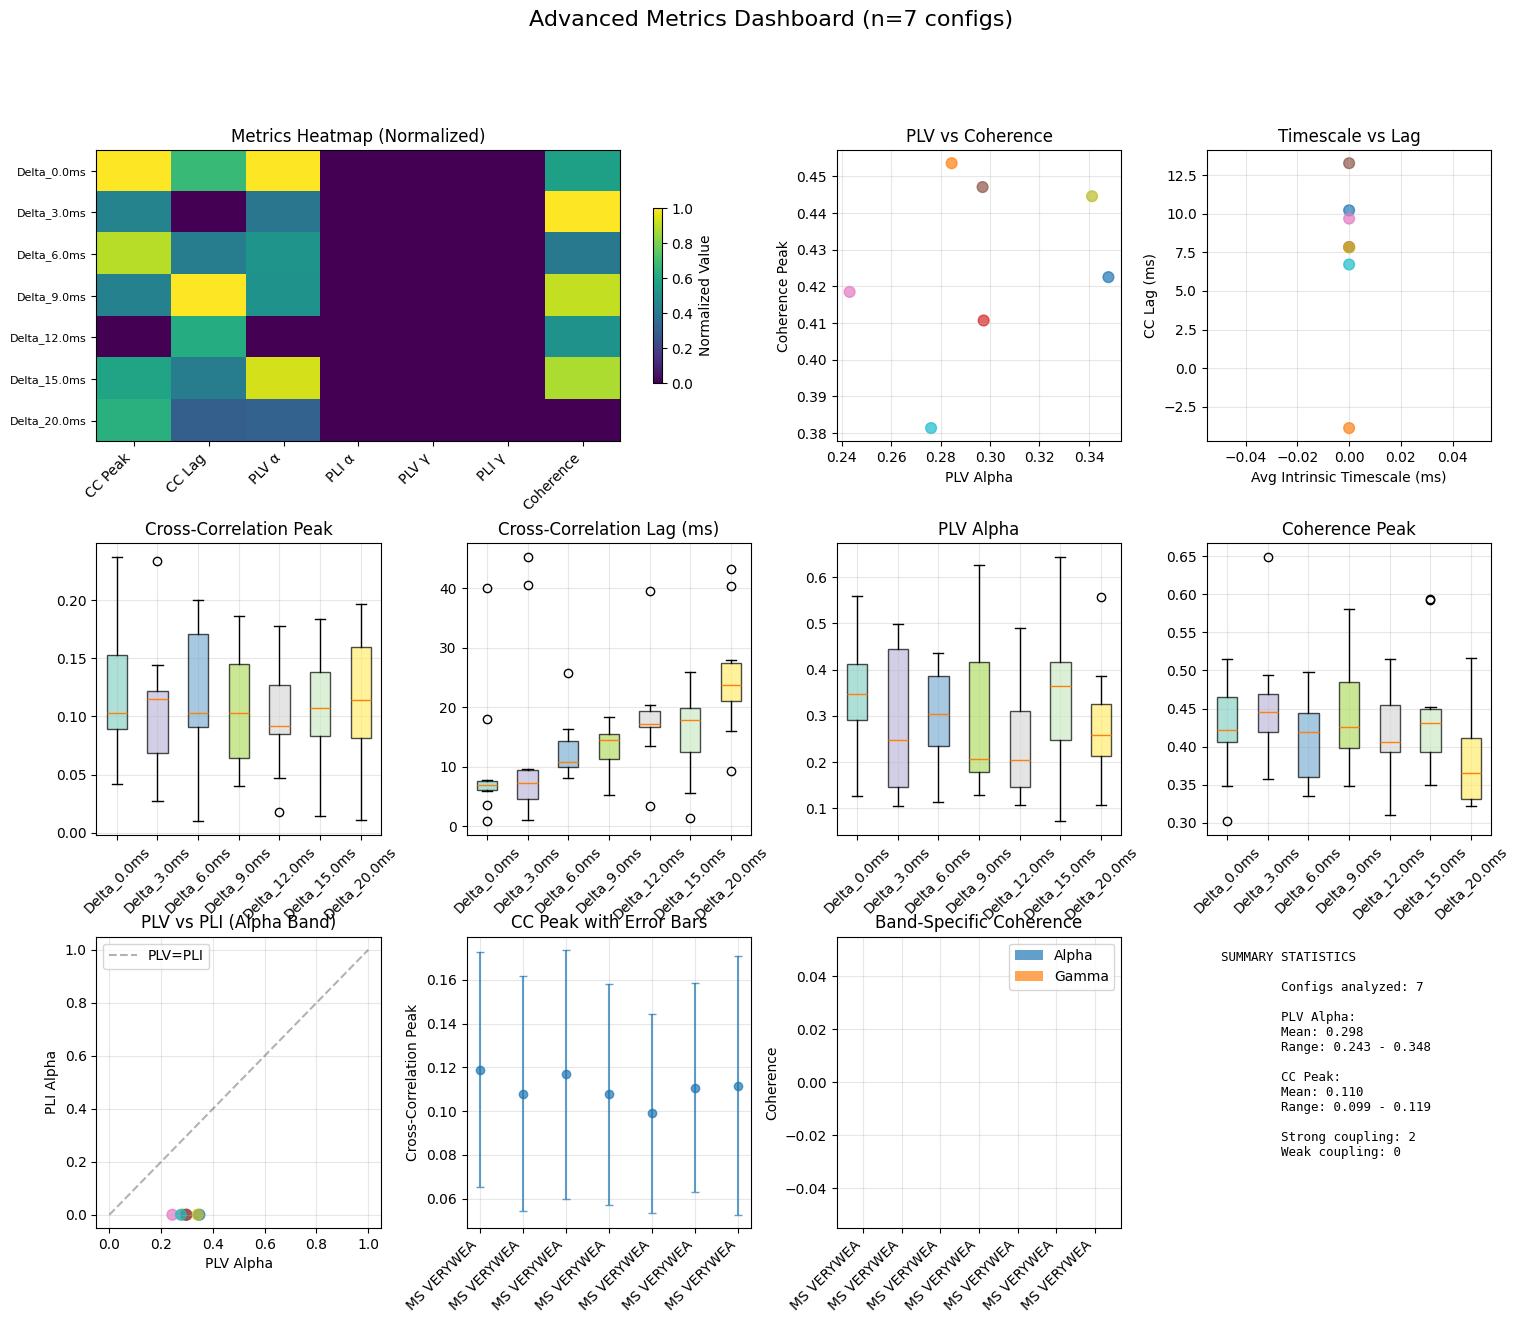

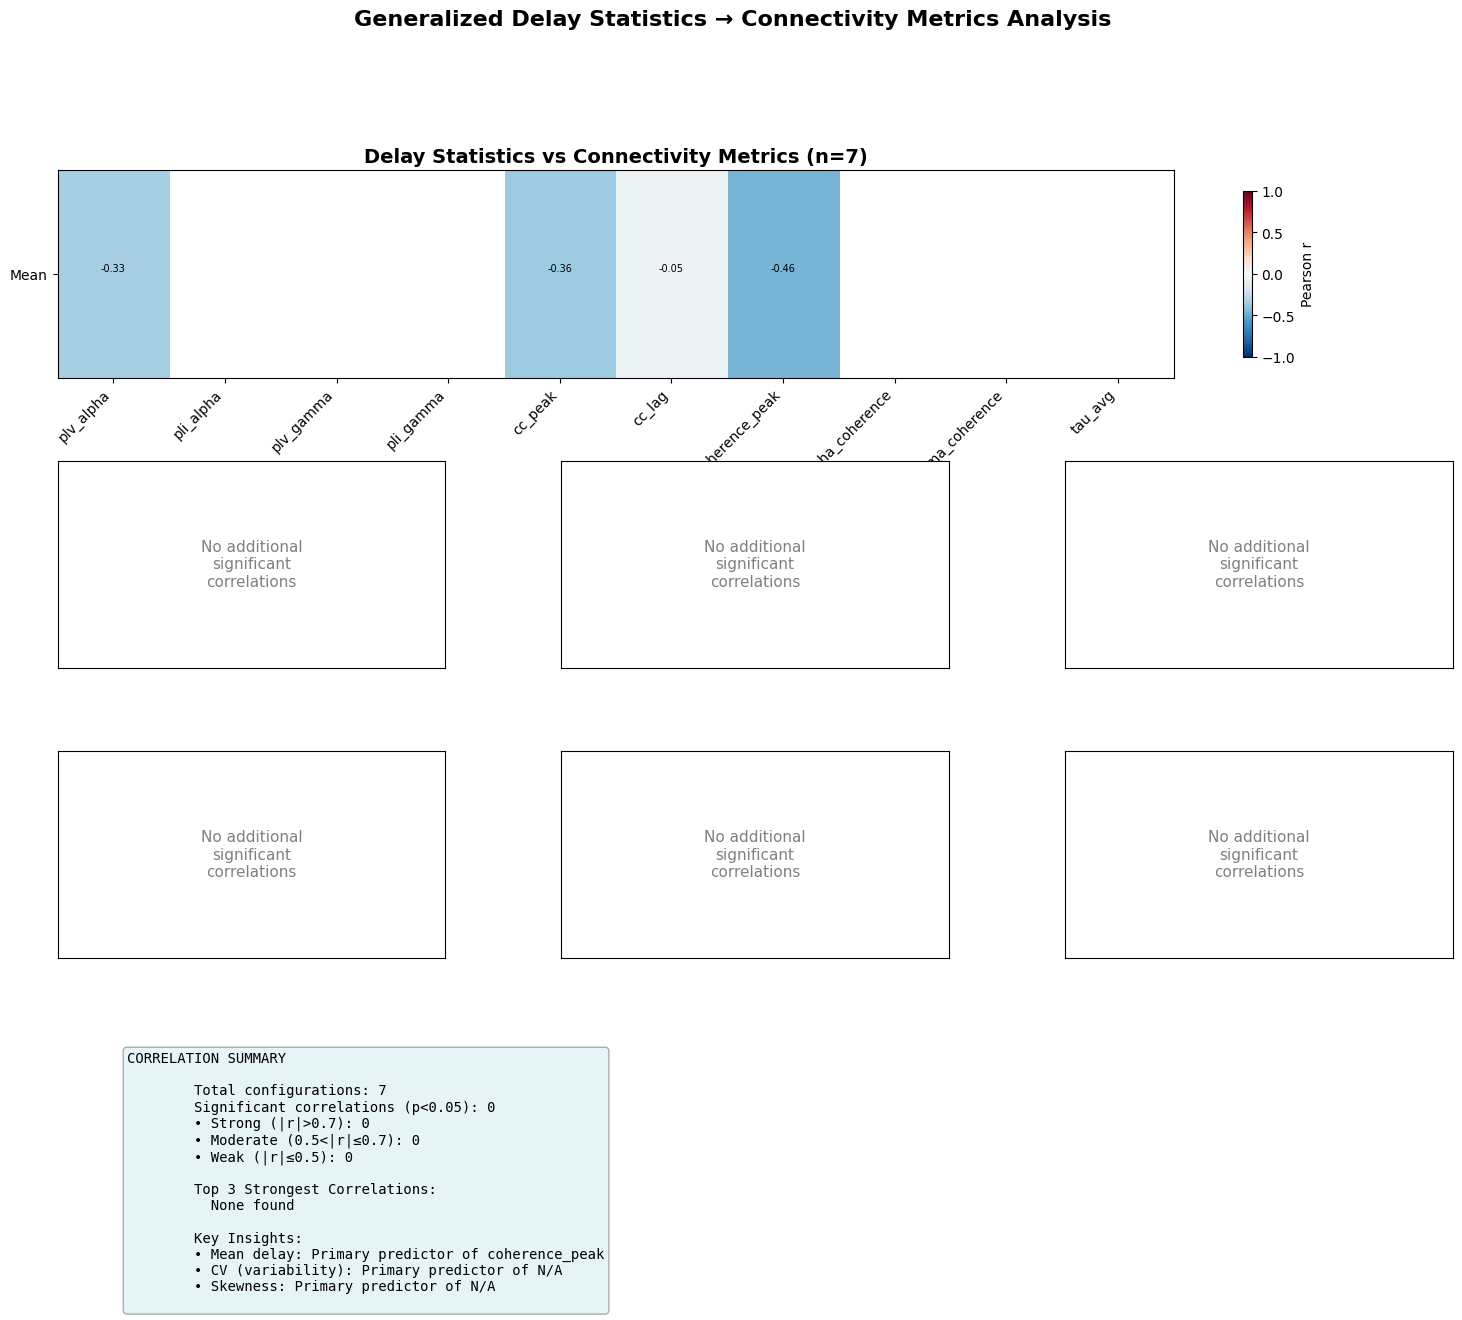

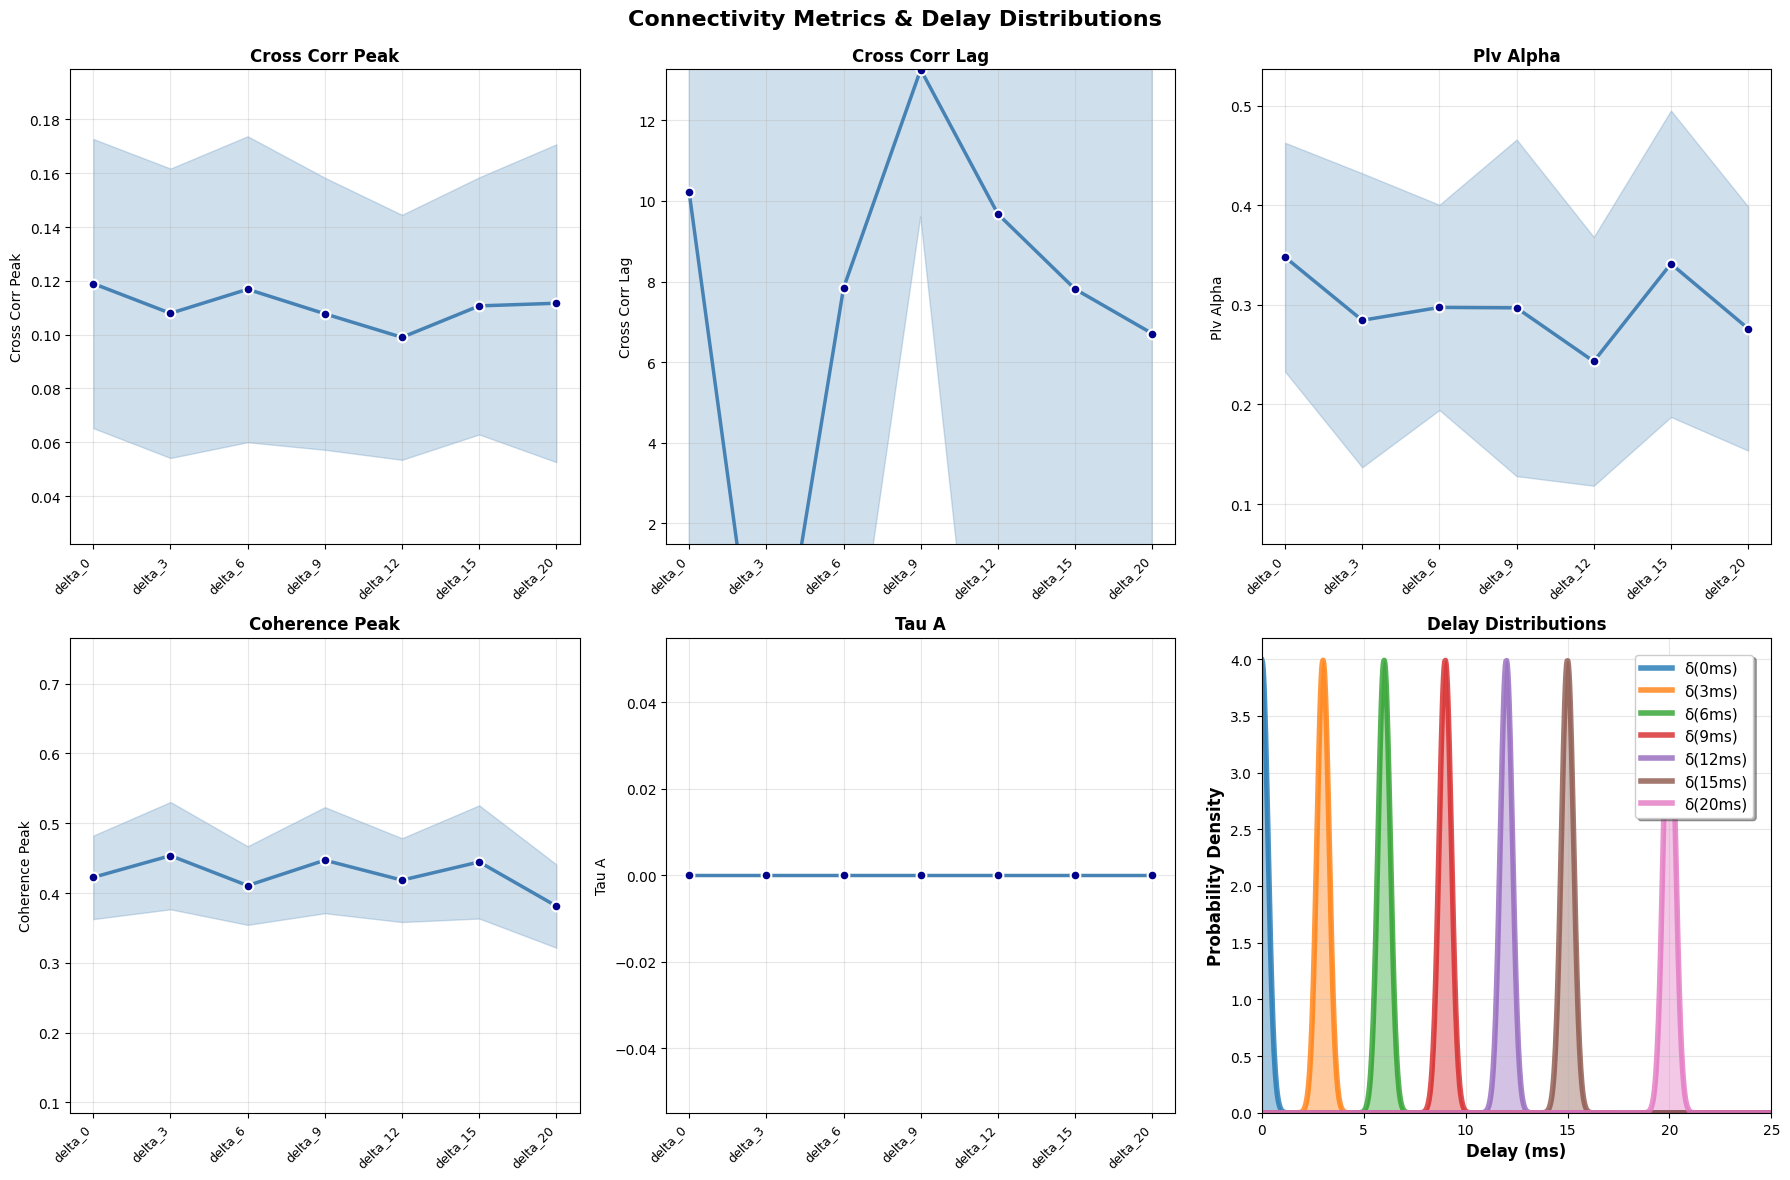

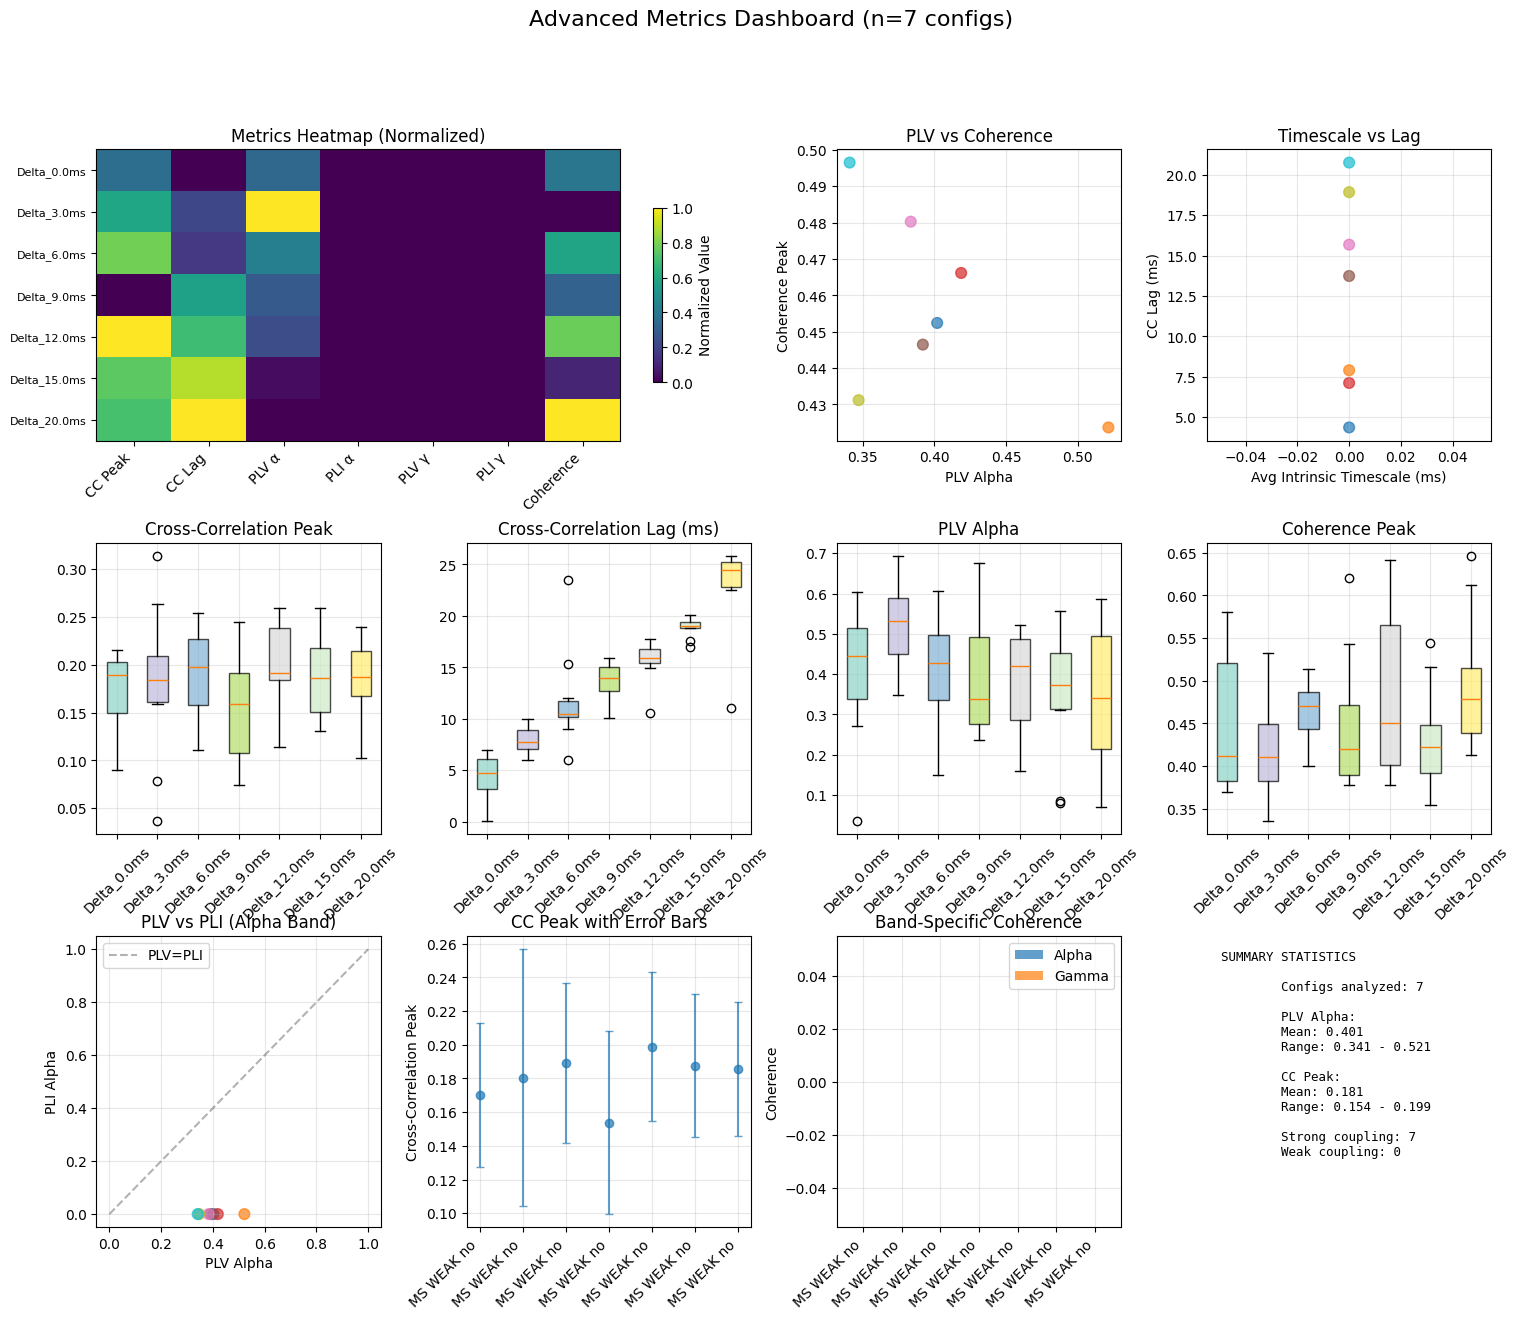

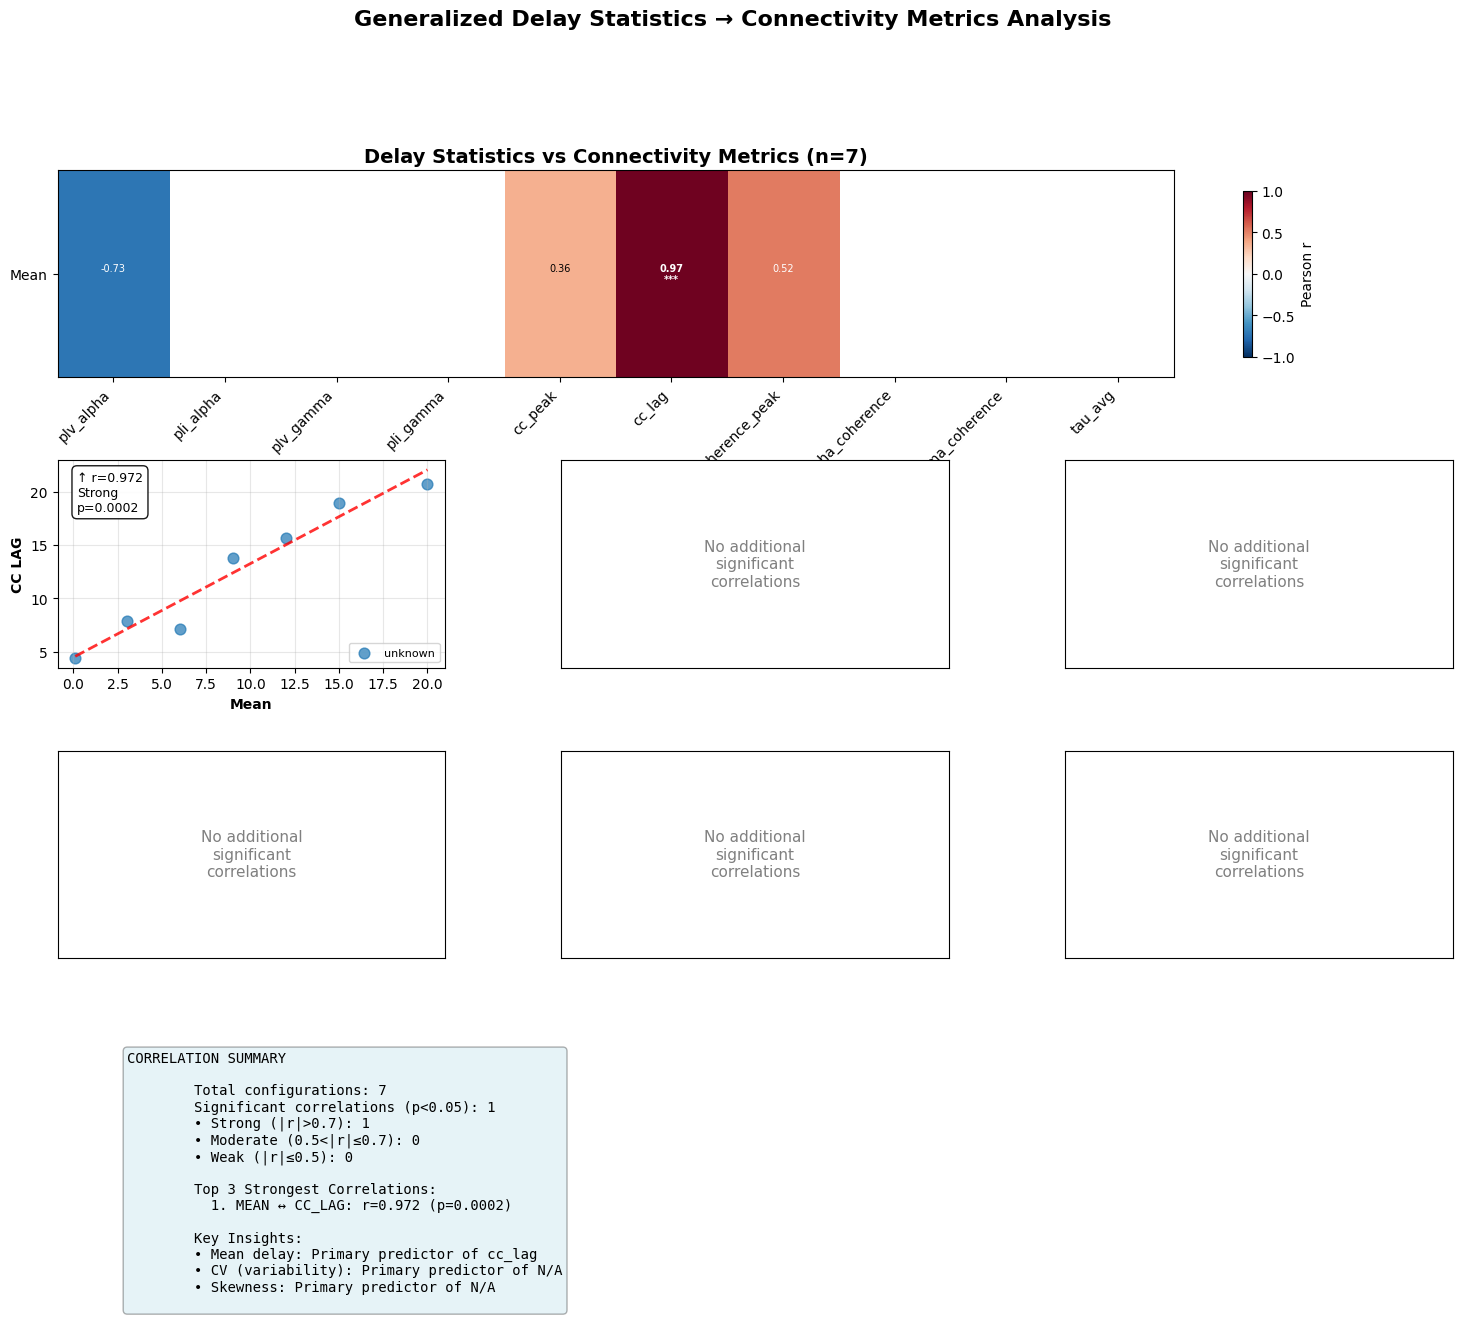

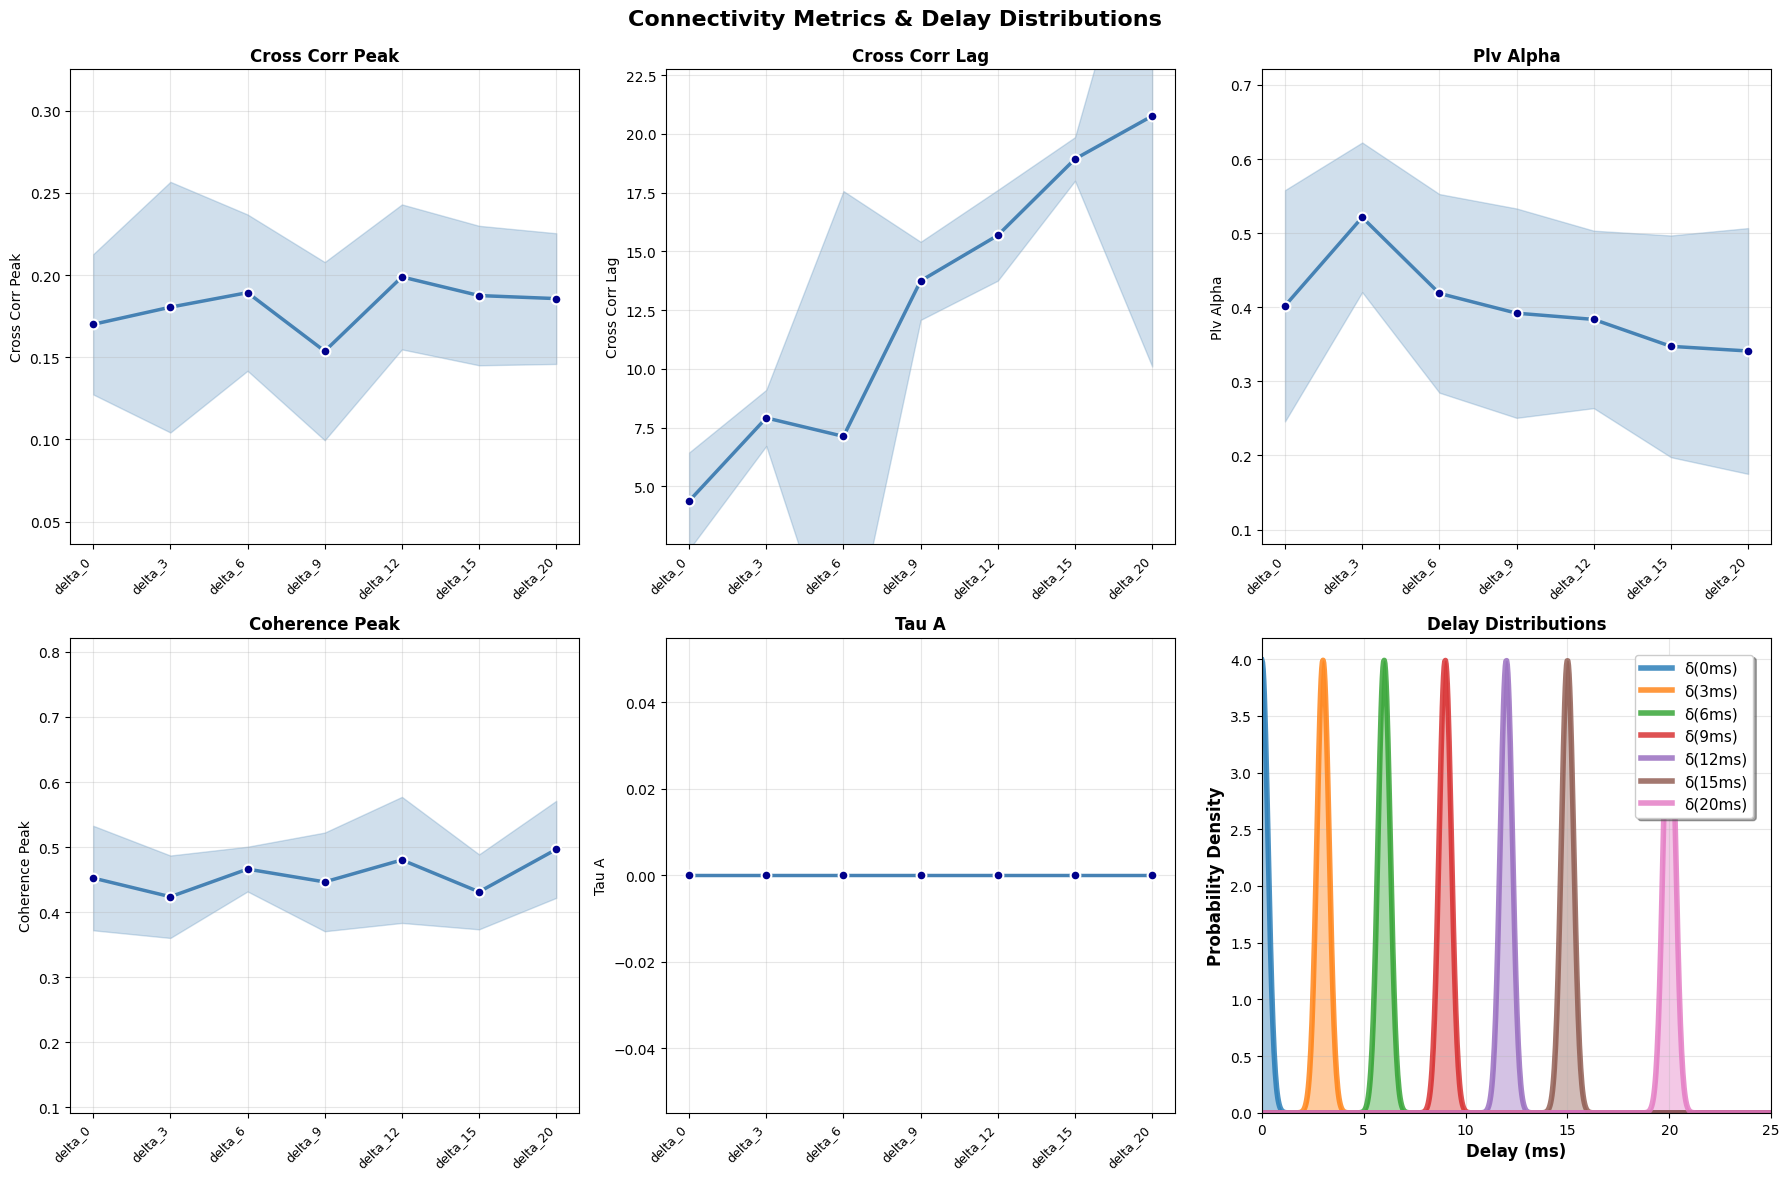

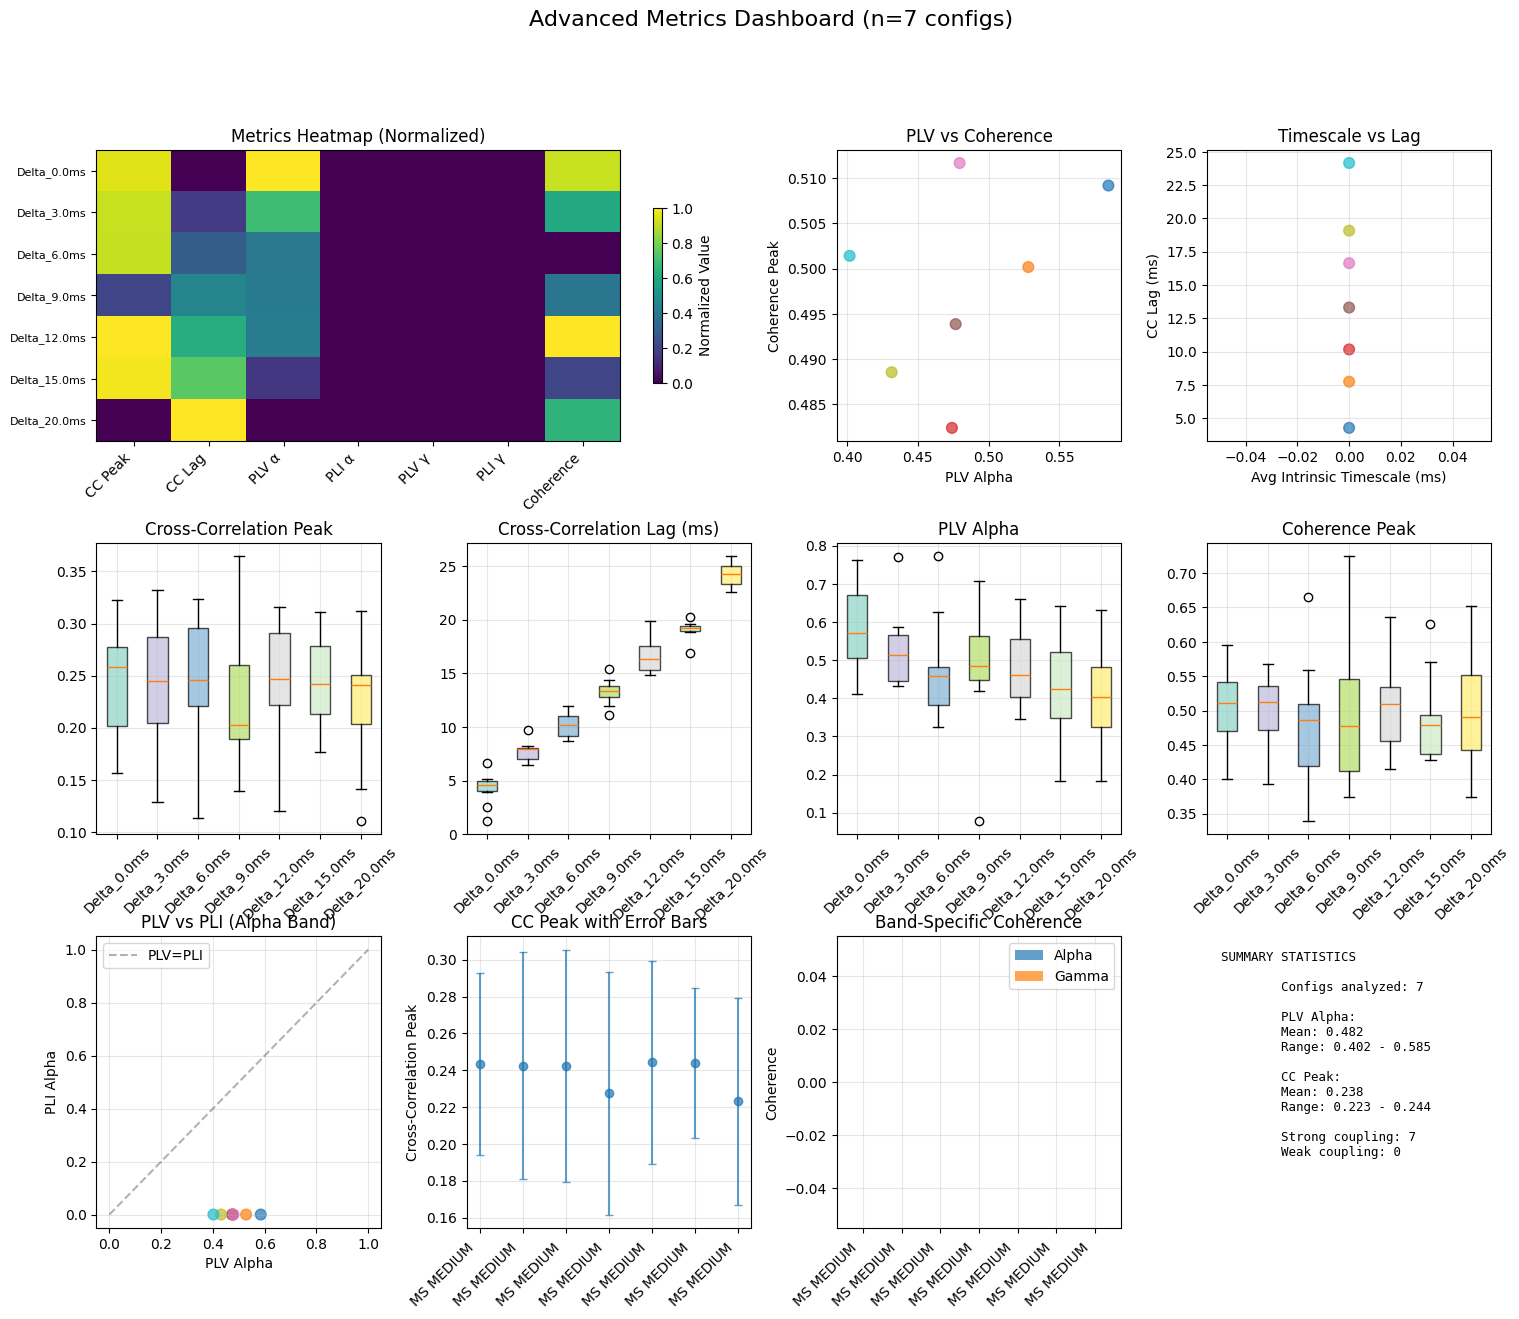

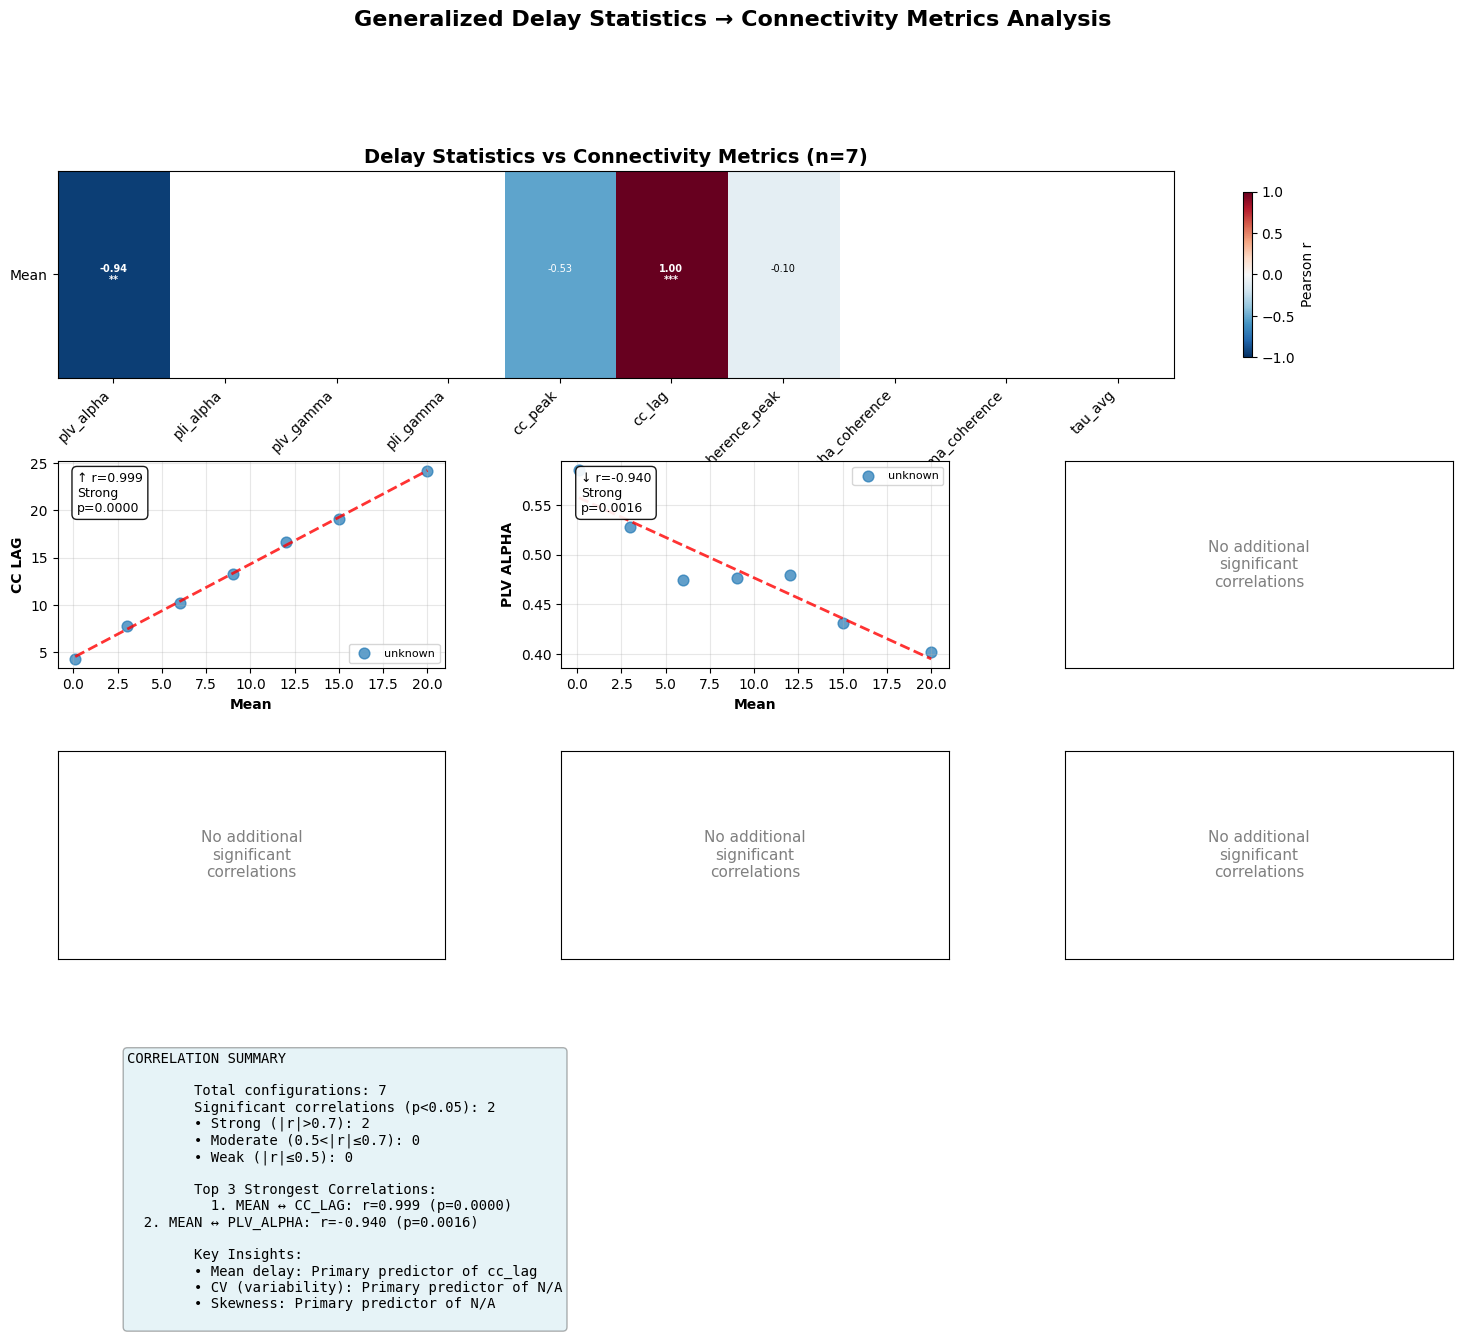

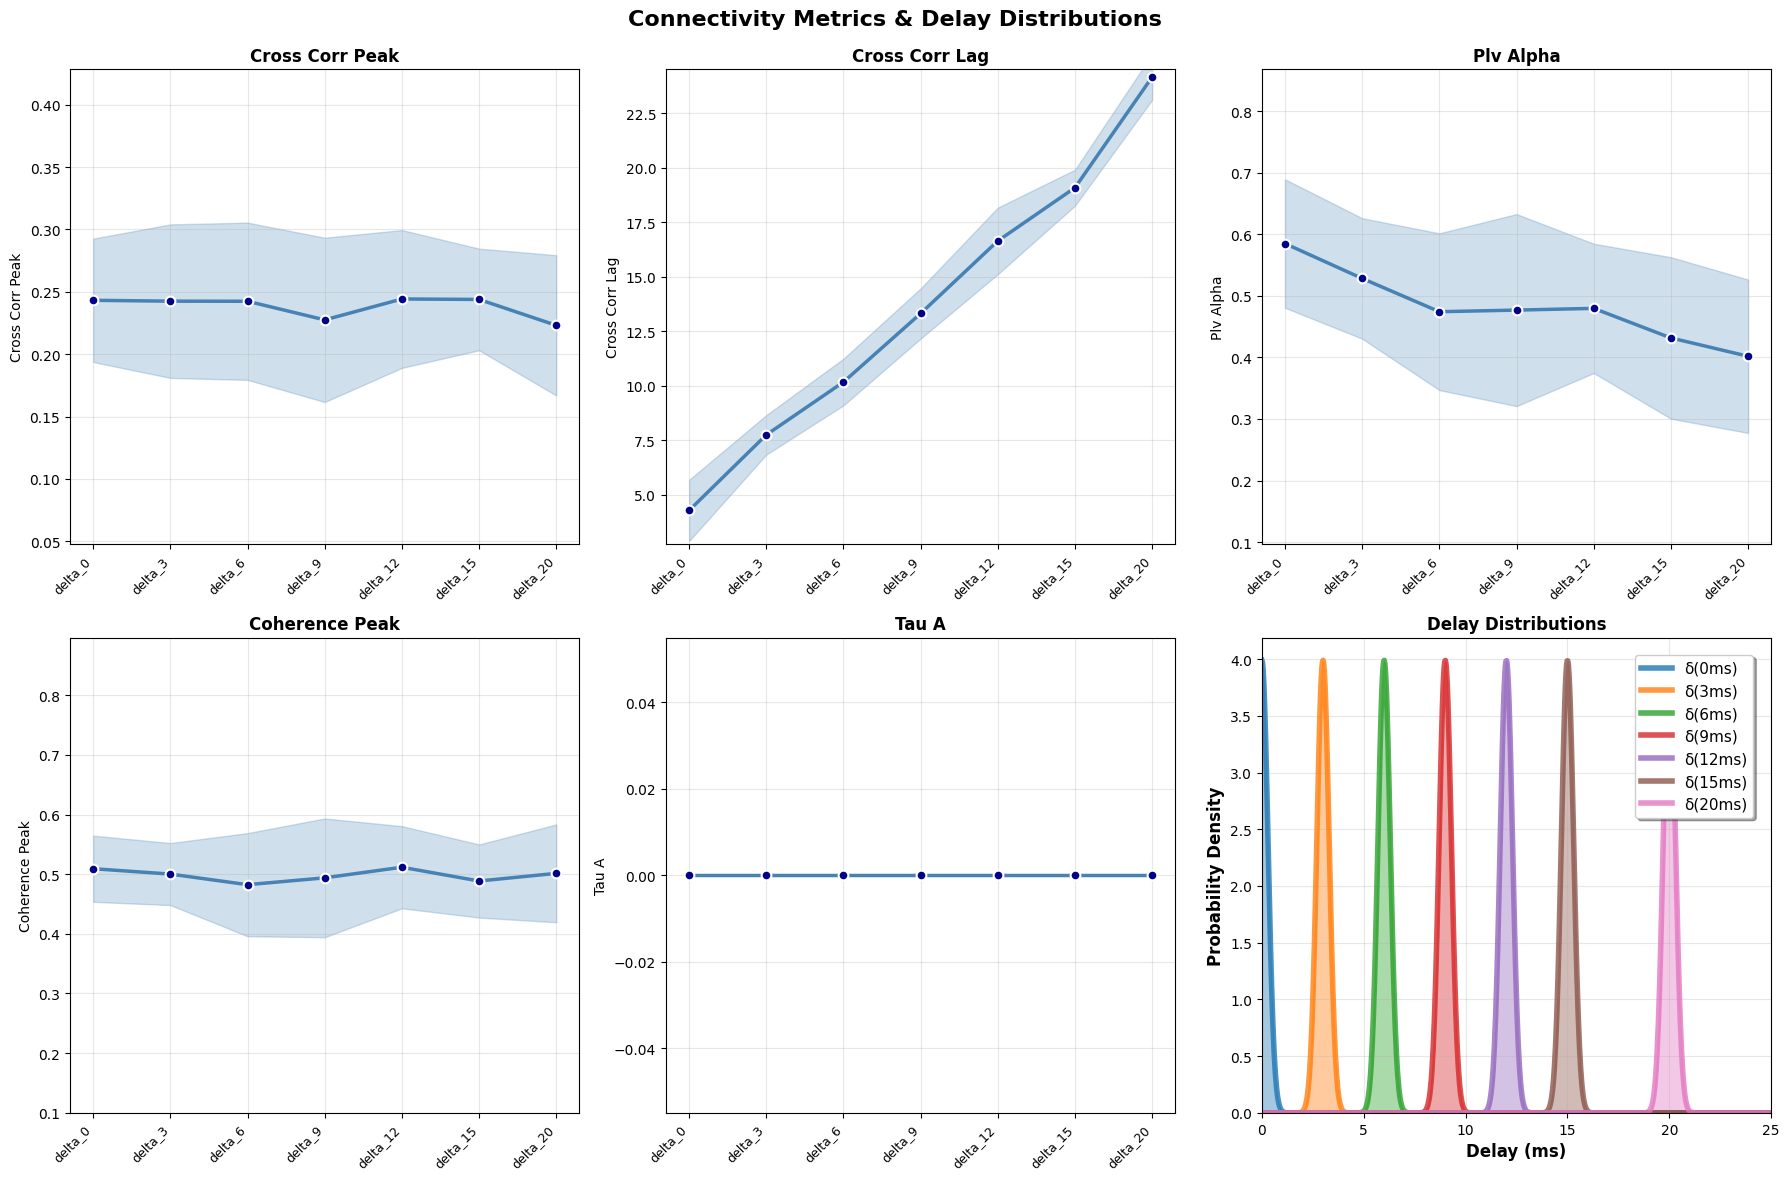

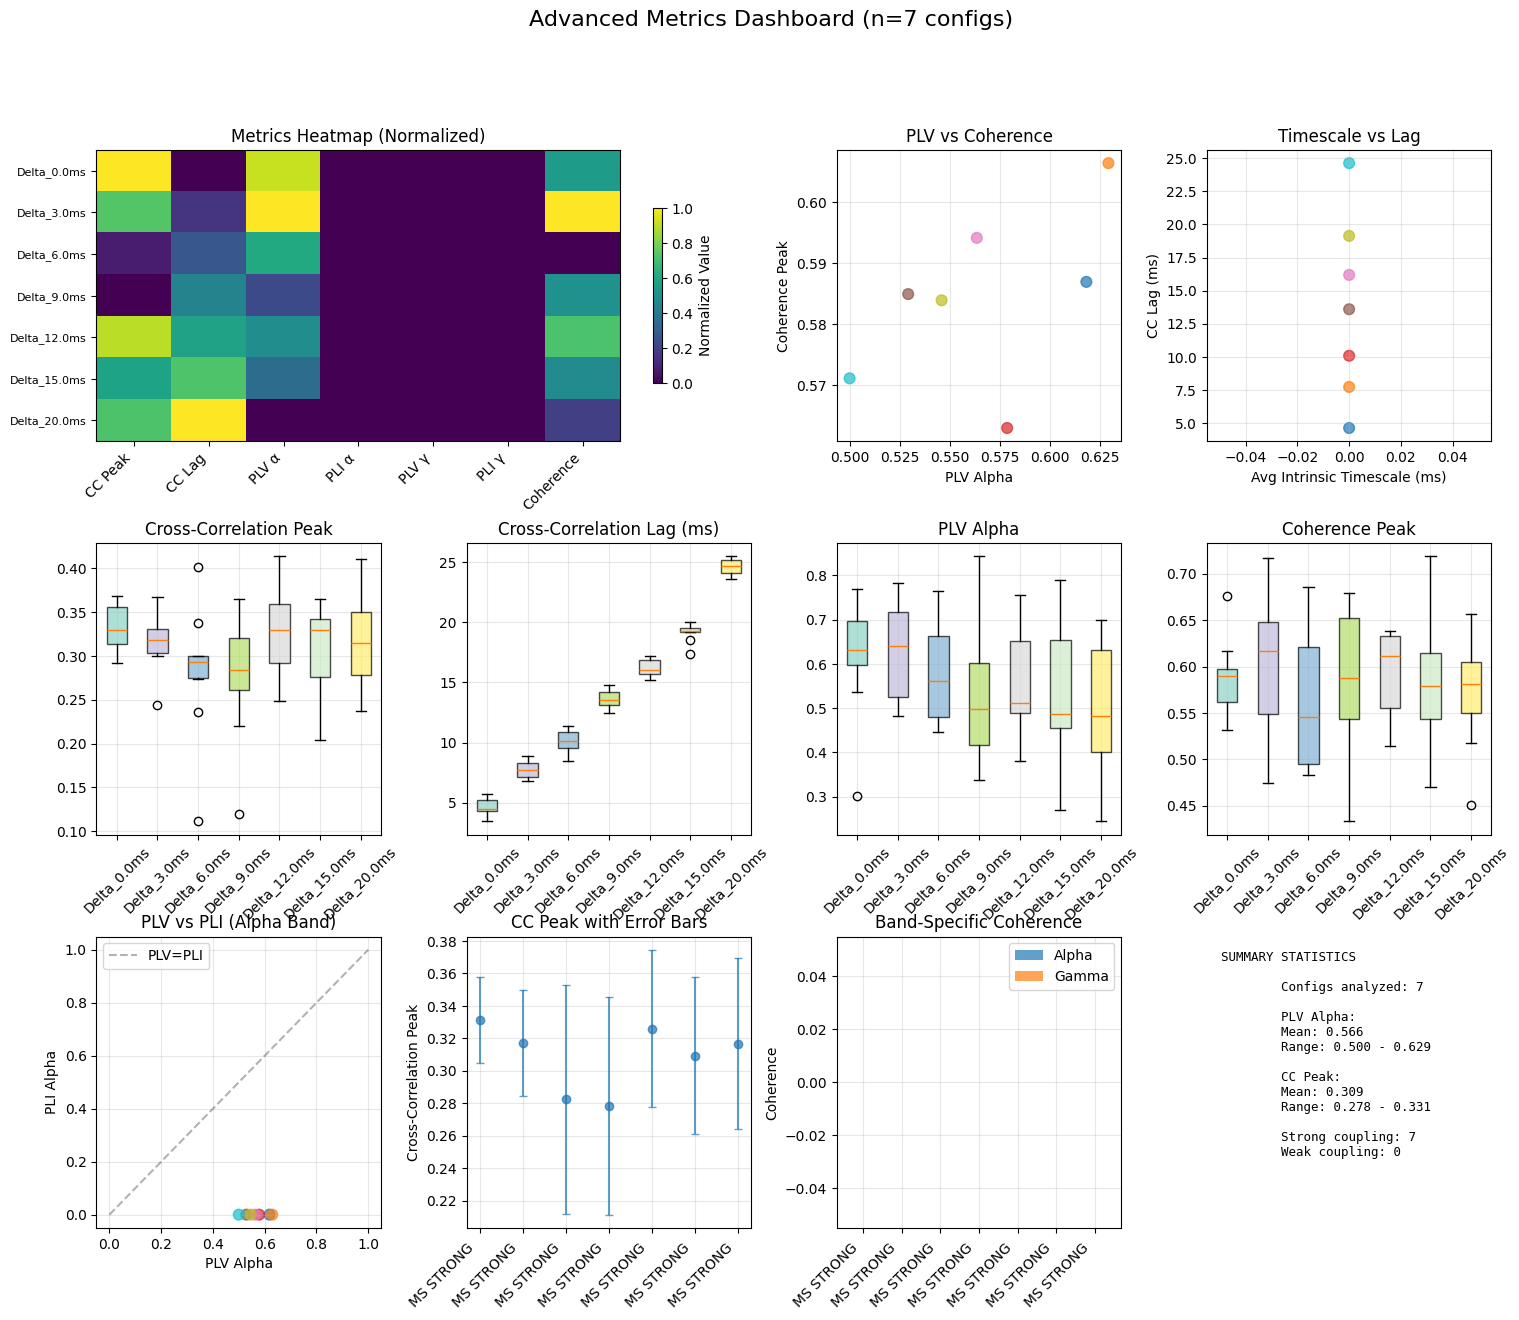

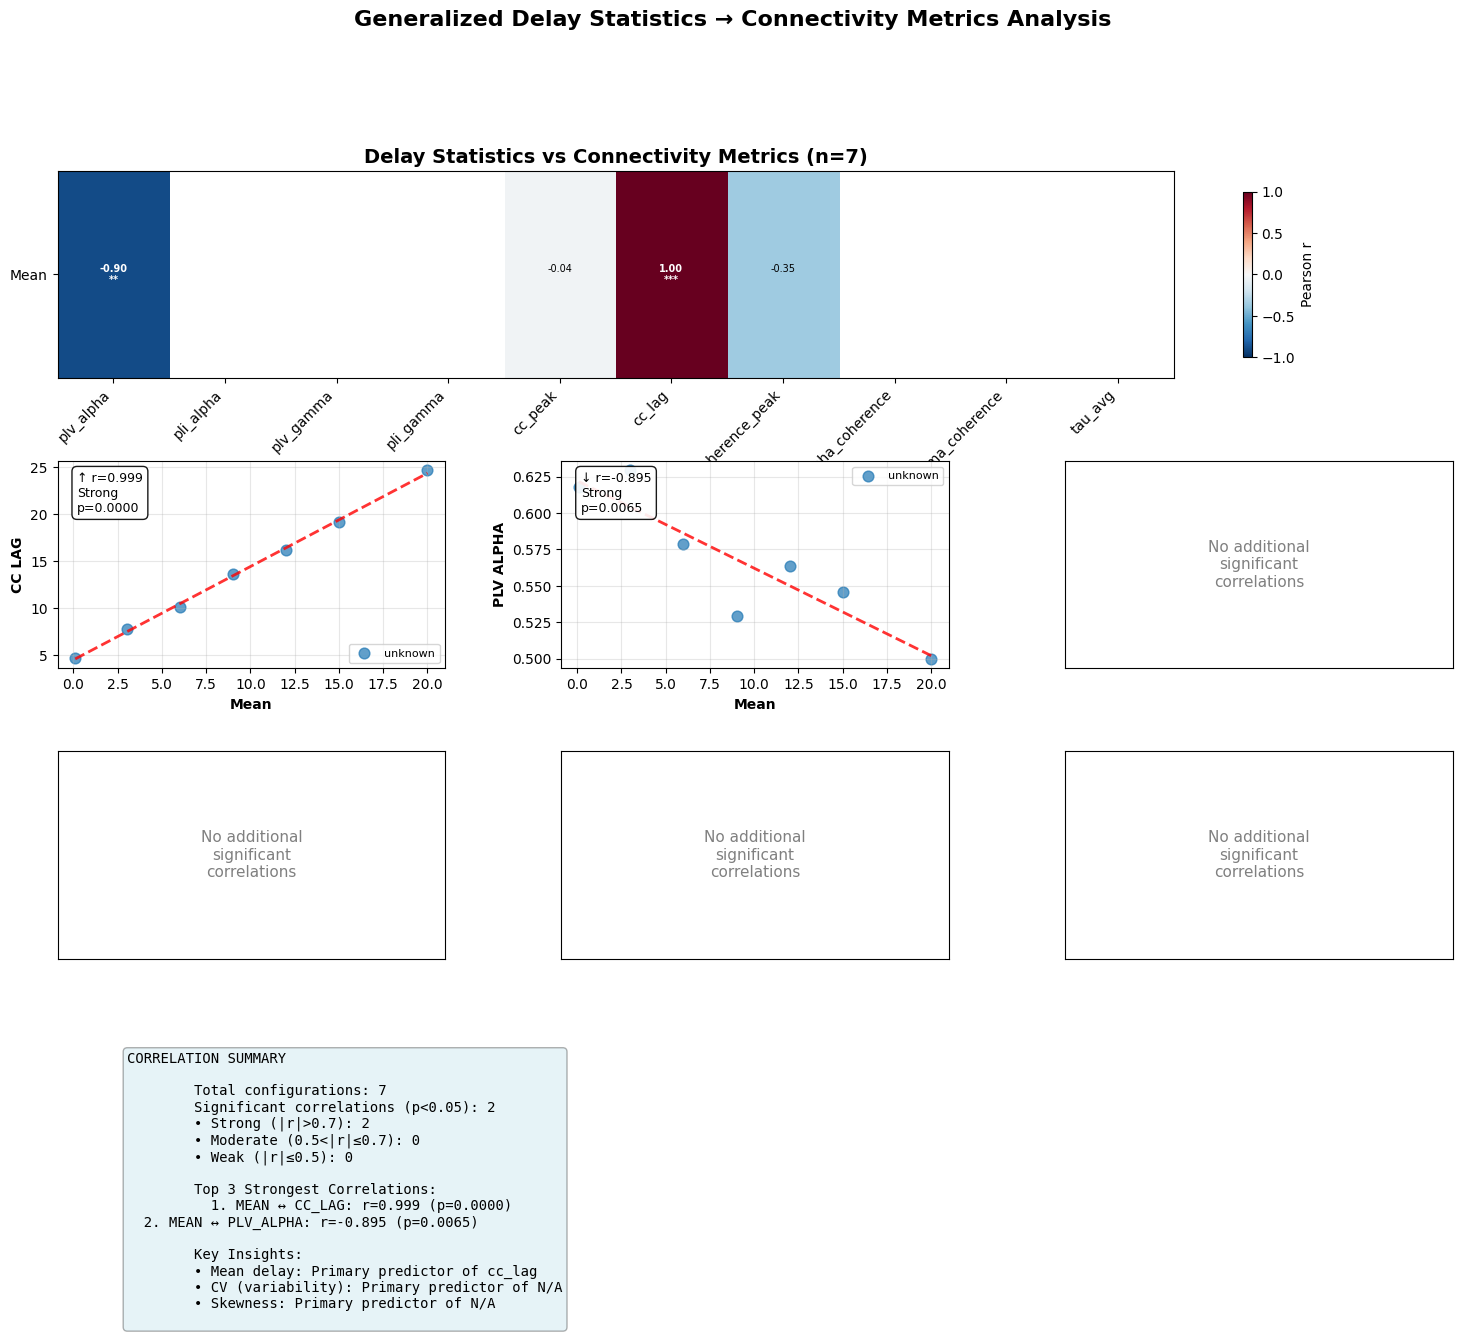

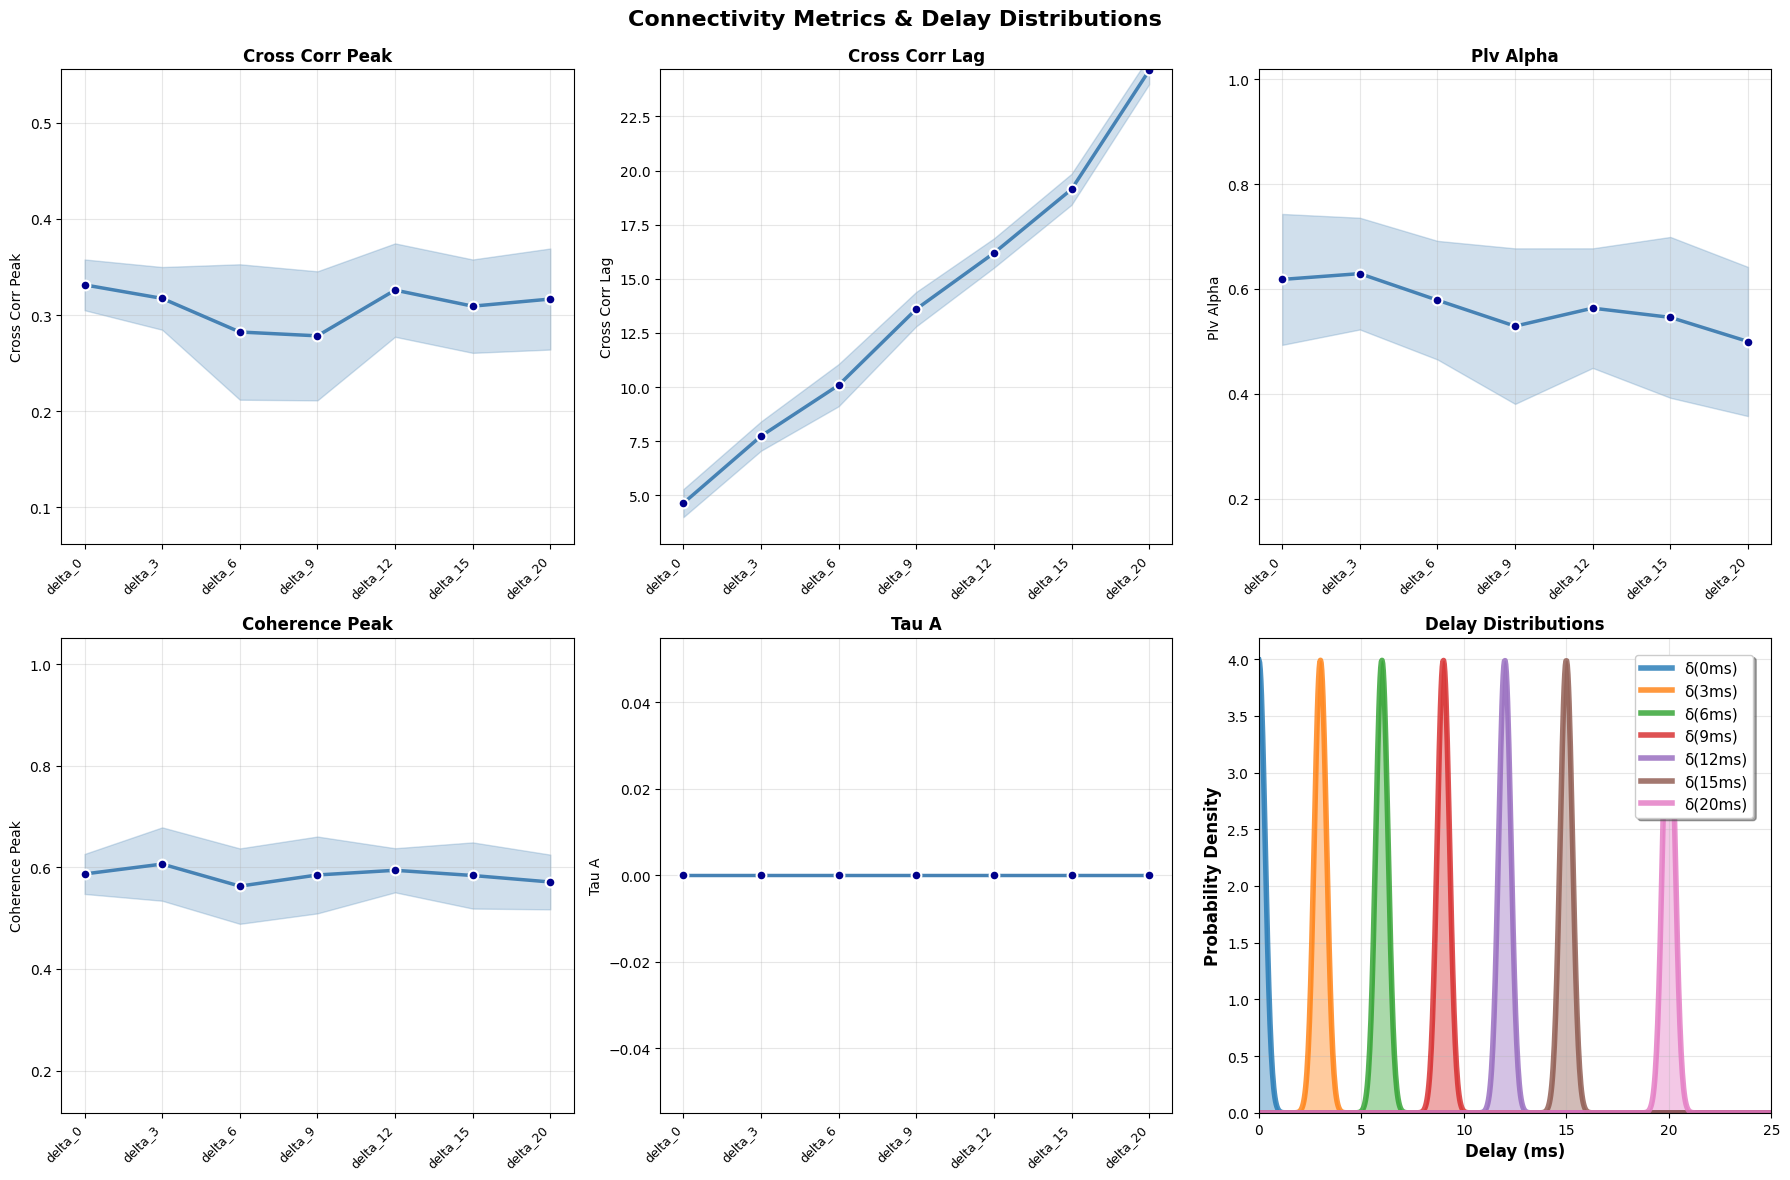

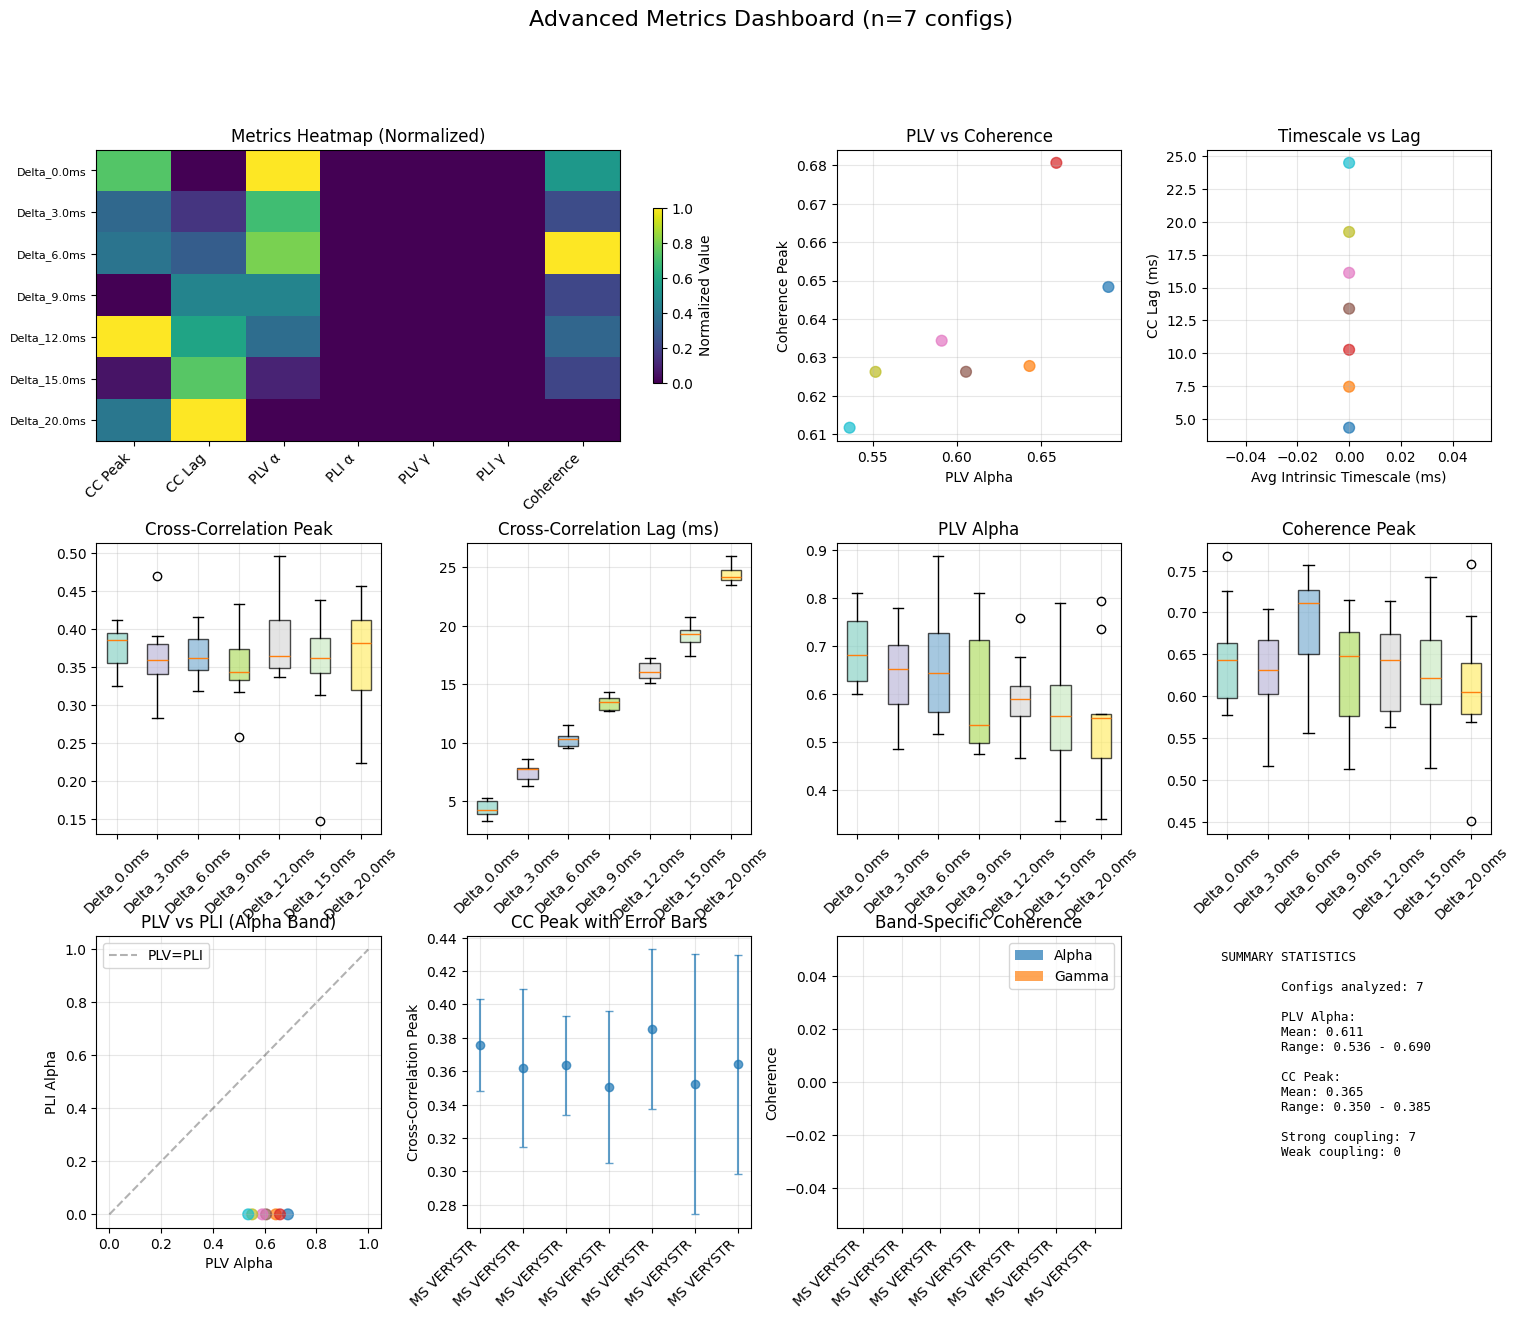

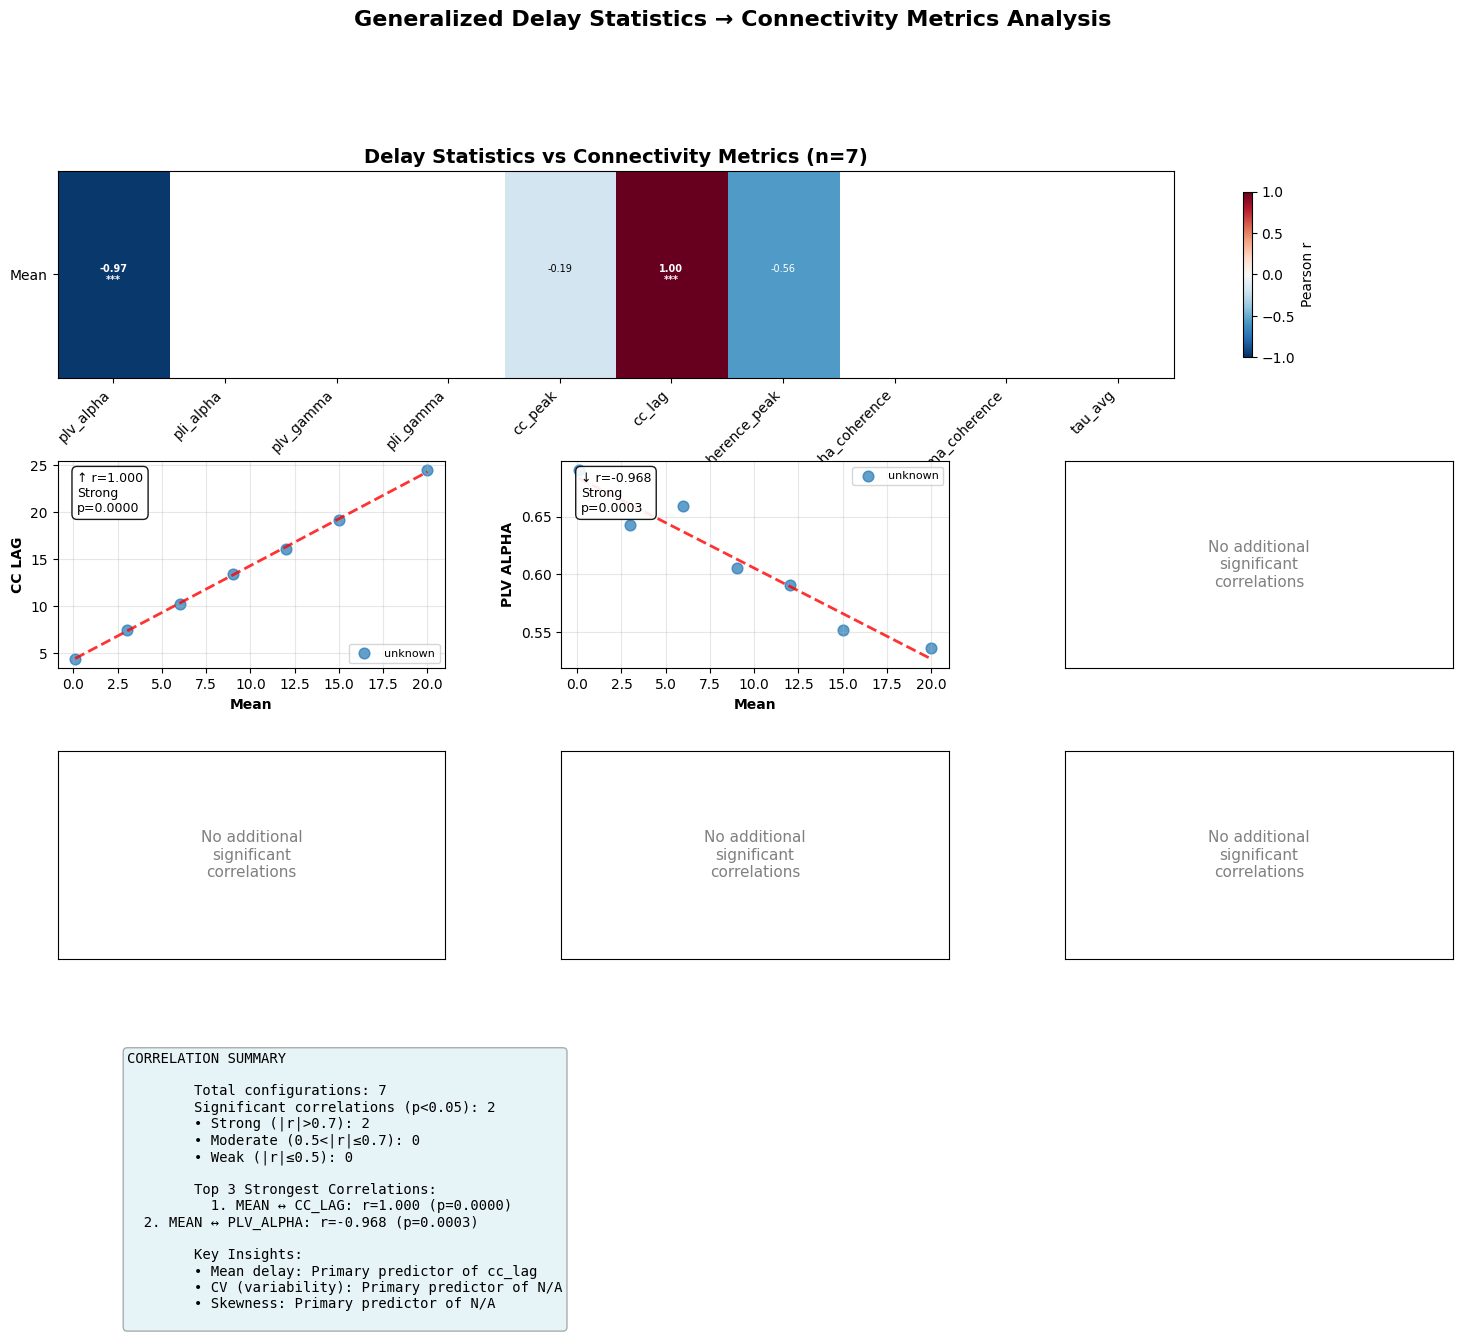

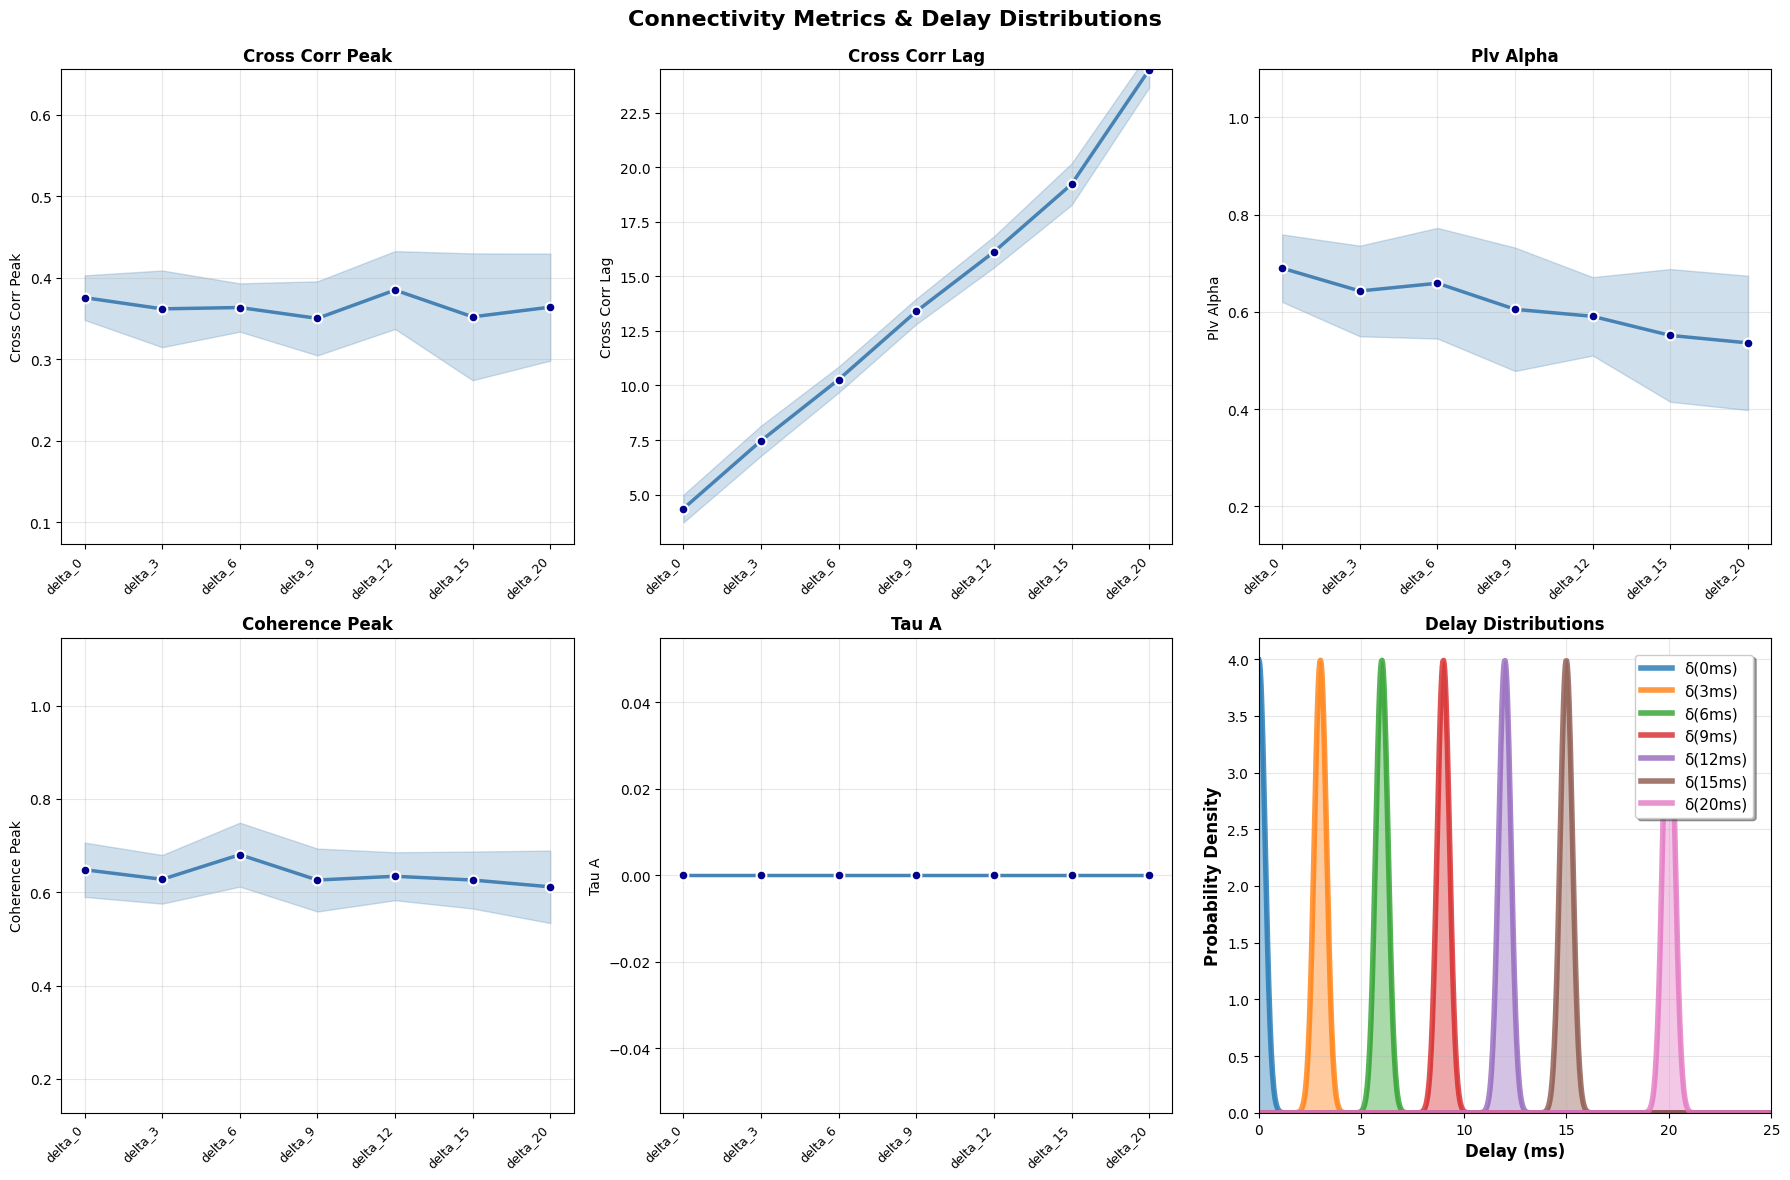

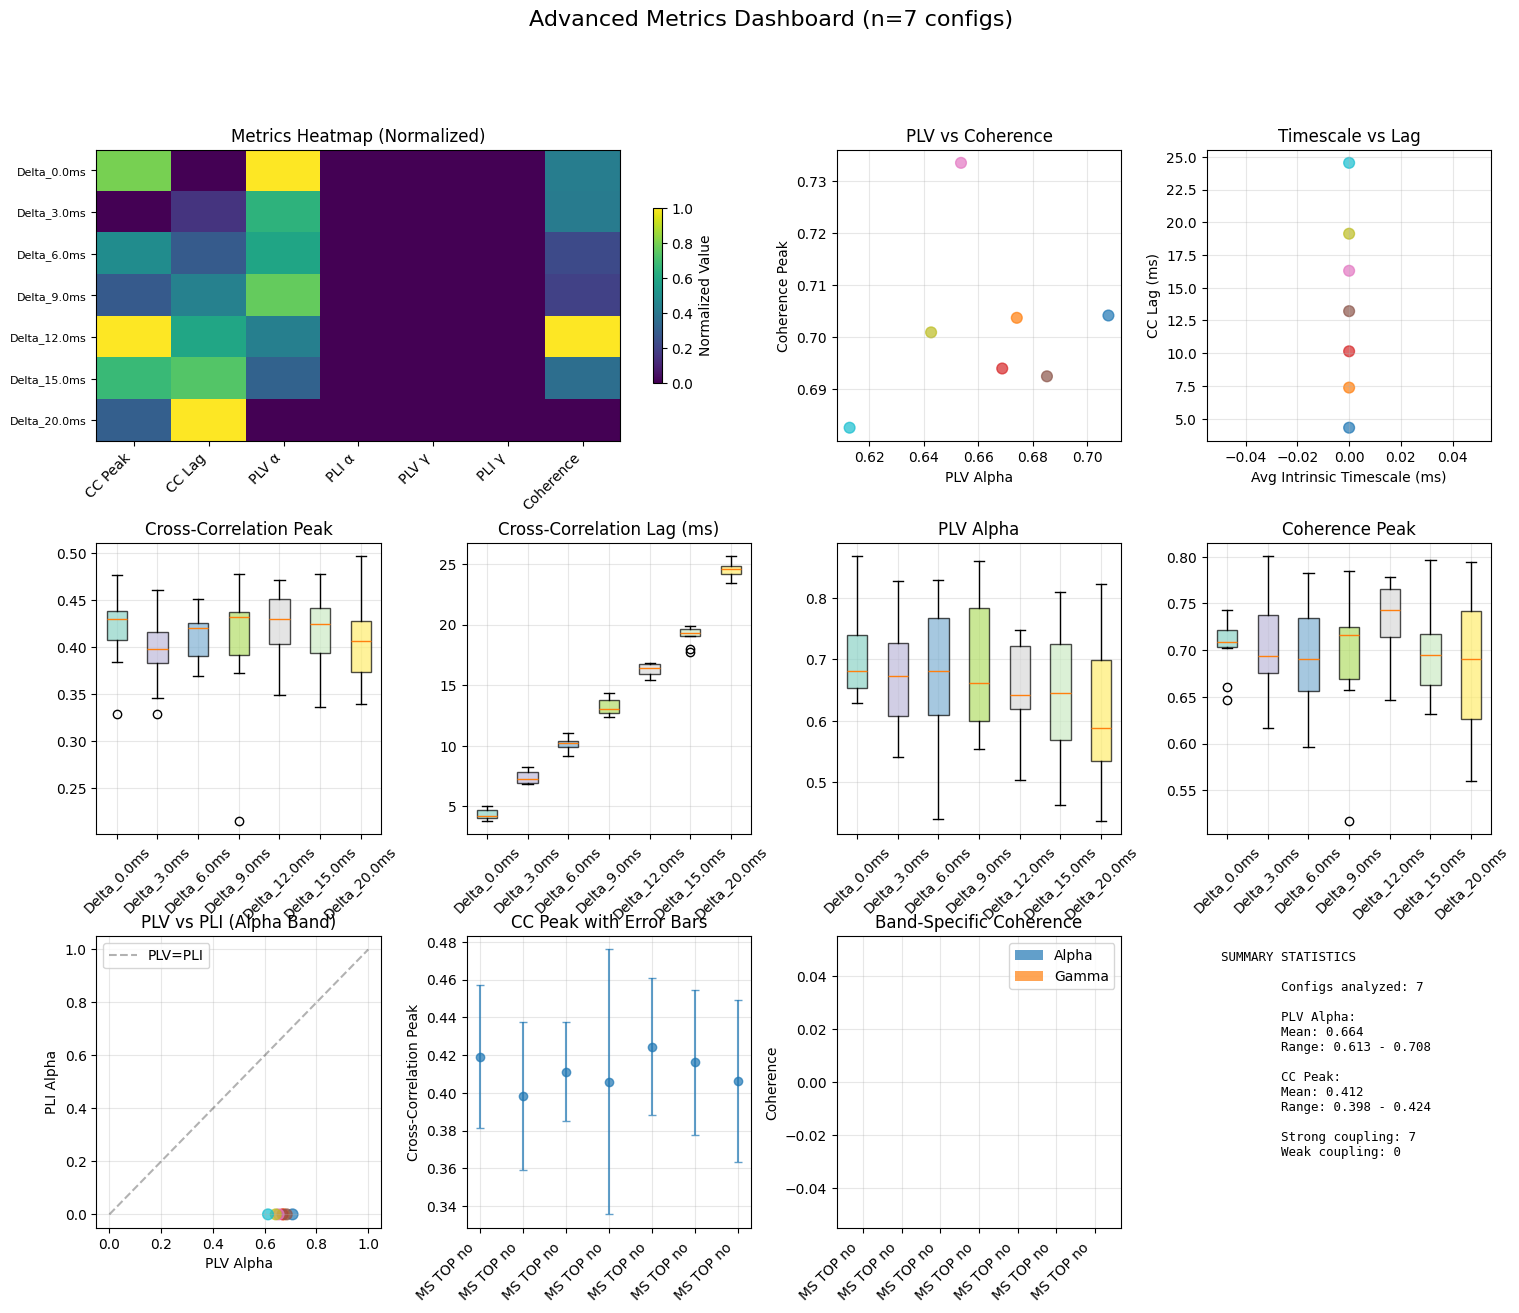

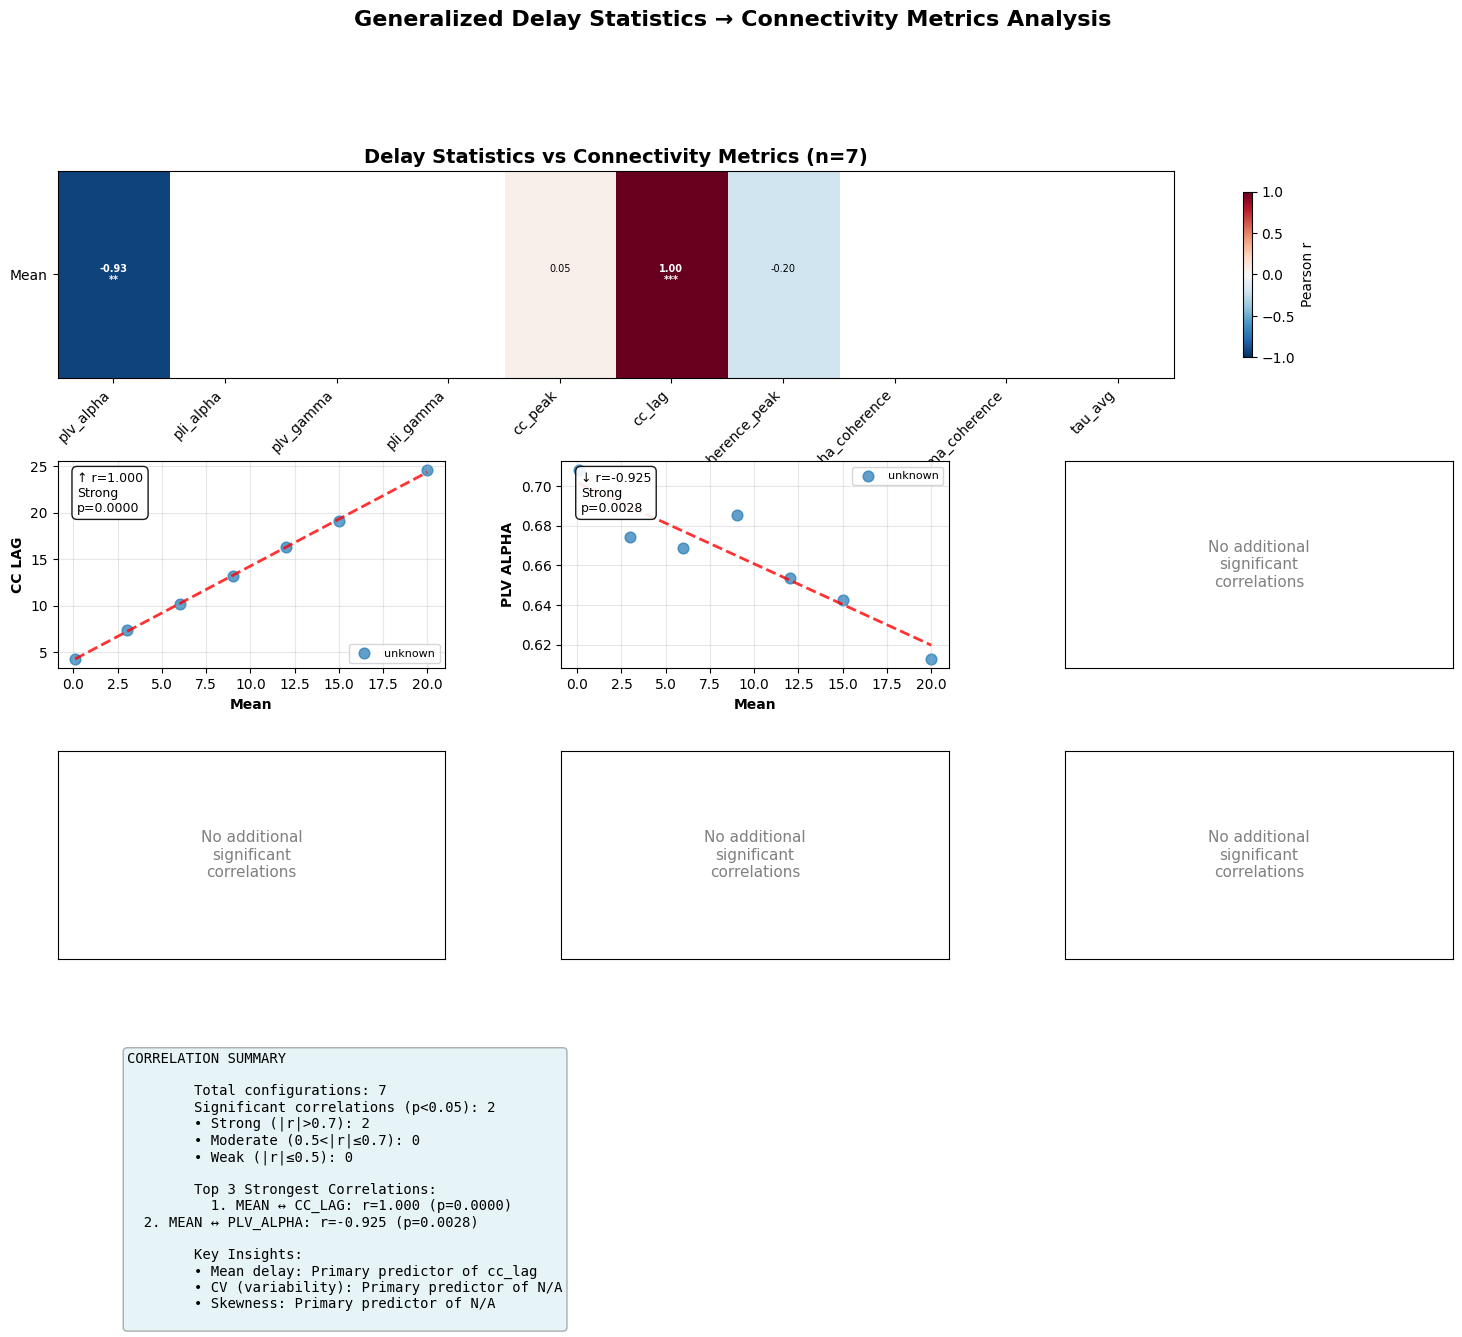

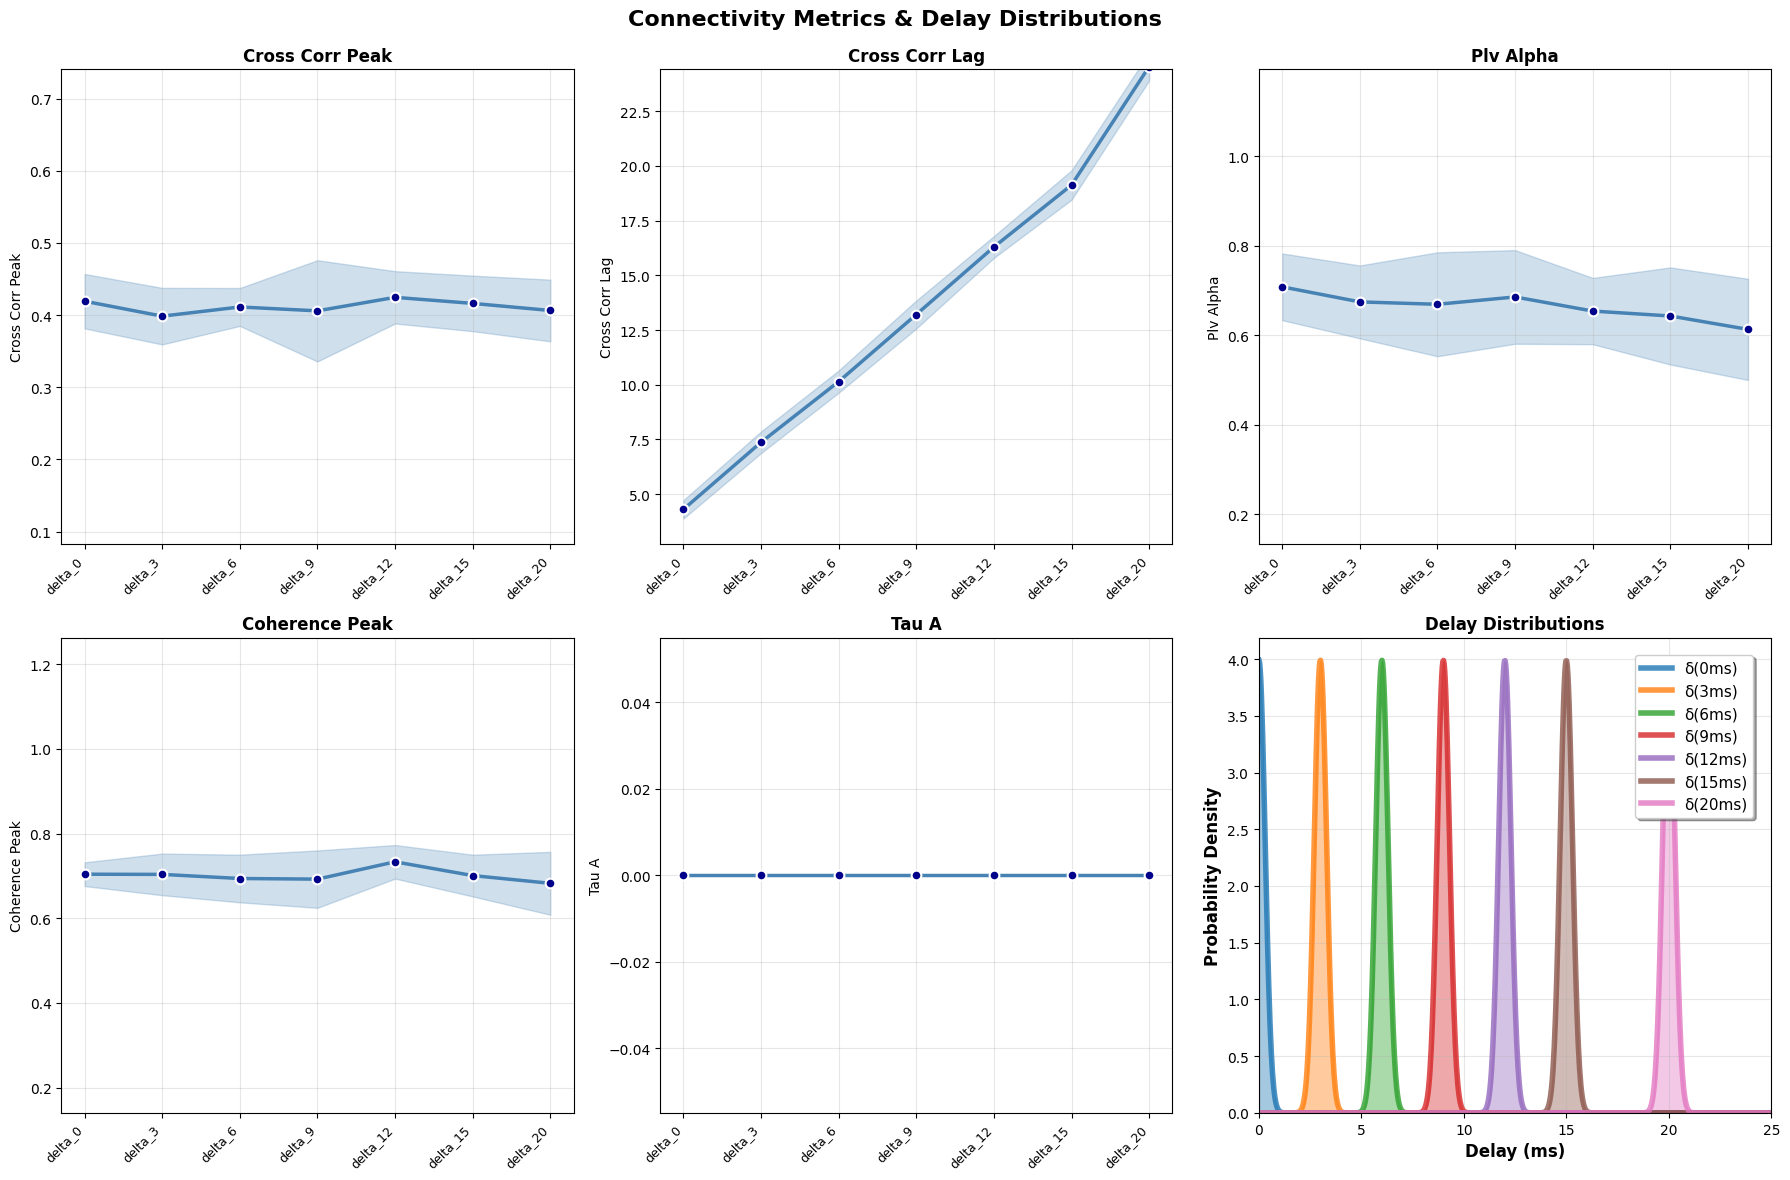

In [8]:
from src.two_populations.helpers.helpers import load_trials_data_for_dashboard
from src.two_populations.plots.plots_sweeps import save_all_sweep_plots

# =============================================================================
# CONFIGURACIÓN DEL EXPERIMENTO
# =============================================================================

# Generador maestro
delay_generators = {
    'uniform': get_uniform_delays,
    'lognormal': get_lognormal_delays,
    'gamma': get_gamma_delays,
    'delta': get_delta_delays,
    'beta': get_beta_delays
}

# Parámetros del sweep
EXPERIMENT_NAME = "DELAY_DISTRIBUTION_STUDY"
COUPLING_STRENGTHS = {
    # 'NULL': 0.0,
    'VERYWEAK': 0.15,
    'WEAK': 0.3,
    'MEDIUM': 0.45, 
    'STRONG': 0.6,
    'VERYSTRONG': 0.75,
    'TOP': 1.0
}

# Configuración temporal y computacional
SIMULATION_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': 4000,
    'n_trials': 10,
    'device_mode': DEVICE_MODE,  # From previous cell
    'directionality': 0,
    'multiprocessing_workers': min(10, multiprocessing.cpu_count())
}


logger.info("✓ Configuration loaded")
logger.info(f"Available coupling strengths: {list(COUPLING_STRENGTHS.keys())}")

# Resumen de configuración
logger.info(f"{'='*60}")
logger.info(f"EXPERIMENT CONFIGURATION")
logger.info(f"{'='*60}")
logger.info(f"Name: {EXPERIMENT_NAME}")
logger.info(f"Device: {DEVICE_MODE}")
logger.info(f"Trials per config: {SIMULATION_CONFIG['n_trials']}")
logger.info(f"Simulation duration: {SIMULATION_CONFIG['T_ms']} ms")
logger.info(f"Workers: {SIMULATION_CONFIG['multiprocessing_workers']}")
logger.info(f"{'='*60}")

ts = datetime.now().strftime("%Y%m%d_%H%M%S")

for coupling_name in COUPLING_STRENGTHS.keys():
    

    # =============================================================================
    # SELECCIÓN DEL EXPERIMENTO A EJECUTAR
    # =============================================================================

    # Choose coupling strength and delay type
    SELECTED_COUPLING = coupling_name  # Change this: WEAK, MEDIUM, SEMISTRONG, STRONG
    SELECTED_DELAYS = 'delta'  # Change this: uniform, gaussian, delta, beta, lognormal

    # Generate experiment configuration
    coupling_value = COUPLING_STRENGTHS[SELECTED_COUPLING]
    coupling_value_str = str(coupling_value).replace('.', 'p')

    # Create experiment tag
    TAG = f"MS_step_gaussian_input_{SELECTED_DELAYS.upper()}_{SELECTED_COUPLING}_k4p5_dt{str(SIMULATION_CONFIG['dt_ms']).replace('.','p')}_T{SIMULATION_CONFIG['T_ms']}_{SIMULATION_CONFIG['n_trials']}trials"

    # Get delay configurations
    prefix = f"MS_{SELECTED_COUPLING}_no_step_gaussian_input"
    
    delay_configs = delay_generators[SELECTED_DELAYS](prefix)
    base_params = get_base_params(coupling_value)

    logger.info(f"Experiment: {TAG}")
    logger.info(f"Delay configurations: {len(delay_configs)}")
    logger.info(f"Base coupling: {coupling_value}")

    # =============================================================================
    # SETUP DE DIRECTORIO Y METADATOS
    # =============================================================================

    sweep_dir = create_sweep_folder(
        base_dir=f"./results/experiments/two_populations/step_input_diff_rois/{ts}",
        tag=TAG, 
        timestamp=''
    )

    # Save experiment configuration
    config_dict = {
        "experiment_name": EXPERIMENT_NAME,
        "tag": TAG,
        "timestamp": ts,
        "coupling_strength": SELECTED_COUPLING,
        "delay_type": SELECTED_DELAYS,
        "simulation_config": SIMULATION_CONFIG,
        "base_params": deepcopy(base_params),
        "delay_configs": deepcopy(delay_configs),
        "seeds": {
            "fixed": 100,
            "variable_range": list(range(200, 200 + SIMULATION_CONFIG['n_trials']))
        }
    }

    save_config_json(config_dict, os.path.join(sweep_dir, "config.json"))
    logger.info(f"Configuration saved to: {sweep_dir}")

    # =============================================================================
    # EJECUCIÓN DEL SWEEP
    # =============================================================================

    # Prepare arguments for multiprocessing
    config_args = [
        (name, config, sweep_dir, SIMULATION_CONFIG['dt_ms'], SIMULATION_CONFIG['T_ms'],
        base_params, SIMULATION_CONFIG['n_trials'], SIMULATION_CONFIG['device_mode'], 
        SIMULATION_CONFIG['directionality'])
        for name, config in delay_configs.items()
    ]
    
    logger.info(f"\n{'='*60}")
    logger.info(f"SWEEP CONFIGURATION")
    logger.info(f"{'='*60}")
    logger.info(f"Experiment: {TAG}")
    logger.info(f"Configurations to run: {len(config_args)}")
    logger.info(f"Trials per config: {SIMULATION_CONFIG['n_trials']}")
    logger.info(f"Total simulations: {len(config_args) * SIMULATION_CONFIG['n_trials']}")
    logger.info(f"Estimated time: ~{len(config_args) * SIMULATION_CONFIG['n_trials'] * 15 / 60:.1f} min")  # ~15s por trial
    logger.info(f"Workers: {SIMULATION_CONFIG['multiprocessing_workers']}")
    logger.info(f"Device: {SIMULATION_CONFIG['device_mode']}")
    logger.info(f"{'='*60}\n")

    # Execute sweep
    start_time = datetime.now()

    if SIMULATION_CONFIG['multiprocessing_workers'] > 1 and len(config_args) > 1:
        # Multiprocessing execution
        with multiprocessing.Pool(SIMULATION_CONFIG['multiprocessing_workers']) as pool:
            completed_configs = pool.map_async(
                run_single_config, config_args
            ).get(timeout=1800)  # 1 hour timeout
    else:
        # Sequential execution (for debugging or single config)
        completed_configs = [run_single_config(args) for args in config_args]

    all_results = completed_configs  # Guardar referencia original
    
    # Filter out failed configs
    successful = [r for r in completed_configs if r and r['status'] == 'SUCCESS']
    failed = [r for r in completed_configs if r and r['status'] == 'FAILED']
    
    logger.info(f"\n{'='*60}")
    logger.info(f"EXECUTION SUMMARY")
    logger.info(f"{'='*60}")
    logger.info(f"✓ Successful: {len(successful)}/{len(config_args)}")
    logger.info(f"✗ Failed: {len(failed)}/{len(config_args)}")
    
    if failed:
        logger.info(f"\n{'='*60}")
        logger.info(f"FAILED CONFIGURATIONS:")
        logger.info(f"{'='*60}")
        for f in failed:
            logger.info(f"  • {f['config']}: {f['error']}")
        
        # Guardar lista de fallidos para re-intentar
        failed_configs_file = os.path.join(sweep_dir, "failed_configs.json")
        with open(failed_configs_file, 'w') as f:
            json.dump(failed, f, indent=2)
        
        logger.info(f"\nFailed configs saved to: {failed_configs_file}")
        
    # Usar solo configs exitosos
    successful_names = [s['config'] for s in successful]

    execution_time = datetime.now() - start_time
    logger.info(f"\nSweep completed in {execution_time}")
    logger.info(f"Successful: {len(successful)}/{len(all_results)}")

    # =============================================================================
    # POST-PROCESAMIENTO Y VISUALIZACIÓN
    # =============================================================================

    if successful_names:
        logger.info("Loading results for analysis...")
        
        # Load aggregated results
        results_db_light = load_results_from_csvs(
            sweep_dir, successful_names, filter_outliers=False
        )
        
        # Cargar trials data
        trials_data = load_trials_data_for_dashboard(sweep_dir, successful_names)
            
        logger.info("\n[PLOTS] Generating comprehensive visualizations...")
        figures, corr_matrix, p_matrix, delay_df, metrics_df = save_all_sweep_plots(sweep_dir, results_db_light, trials_data, dpi=300)

        
        # Summary
        logger.info(f"\n{'='*60}")
        logger.info(f"SWEEP SUMMARY")
        logger.info(f"{'='*60}")
        logger.info(f"Directory: {sweep_dir}")
        logger.info(f"Configurations: {len(successful_names)}")
        logger.info(f"Total trials: {len(successful_names) * SIMULATION_CONFIG['n_trials']}")
        logger.info(f"Execution time: {execution_time}")
        
    else:
        logger.info("No configurations completed successfully!")

    # Display sweep directory for easy access
    logger.info(f"\nSweep directory:\n{sweep_dir}")

In [6]:
# =============================================================================
# QUICK ANALYSIS 
# =============================================================================

import matplotlib.pyplot as plt

if 'results_db_light' in locals() and len(completed_configs) > 0:
    try:
        from src.two_populations.plots.dashboard_plots import plot_advanced_metrics_dashboard, load_trials_data_for_dashboard
        trials_data = load_trials_data_for_dashboard(sweep_dir, completed_configs)
        fig = plot_advanced_metrics_dashboard(results_db_light, trials_data, readable_names=True)
        plt.show()
    except Exception as e:
        logger.info(f"Quick analysis failed: {e}")

INFO       Quick analysis failed: cannot import name 'plot_advanced_metrics_dashboard' from 'src.two_populations.plots.dashboard_plots' (/home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/dashboard_plots.py) [brian2]


In [7]:
# =============================================================================
# SYSTEM DIAGNOSTICS (Optional - for troubleshooting)
# =============================================================================
import psutil
import brian2

logger.info("SYSTEM STATUS")
logger.info("=" * 40)
logger.info(f"RAM available: {psutil.virtual_memory().available / 1e9:.1f} GB")
logger.info(f"RAM total: {psutil.virtual_memory().total / 1e9:.1f} GB")
logger.info(f"CPU cores: {multiprocessing.cpu_count()}")
logger.info(f"Brian2 version: {brian2.__version__}")
logger.info(f"Brian2 device: {brian2.get_device()}")

if hasattr(brian2.prefs.devices, 'cpp_standalone'):
    logger.info(f"OpenMP threads: {brian2.prefs.devices.cpp_standalone.openmp_threads}")

INFO       SYSTEM STATUS [brian2]
INFO       ======================================== [brian2]
INFO       RAM available: 7.0 GB [brian2]
INFO       RAM total: 21.0 GB [brian2]
INFO       CPU cores: 12 [brian2]
INFO       Brian2 version: 2.8.0 [brian2]
INFO       Brian2 device: <brian2.devices.device.RuntimeDevice object at 0x7f8efc9aa7d0> [brian2]
INFO       OpenMP threads: 0 [brian2]
